# Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise

## Introduction
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### What We'll Build
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### Dataset Options
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### Resource Requirements
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### Before You Start
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



## Step 1: Setting Up Our Tools
First, let's install and import all the tools we need. Run this cell and wait for it to complete.

In [1]:
# Step 1: Install required packages
%pip install einops
print("Package installation complete.")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
import torch  # Main deep learning framework
import torch.nn.functional as F  # Neural network functions like activation functions
import torch.nn as nn  # Neural network building blocks (layers)
from torch.optim import Adam  # Optimization algorithm for training

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader  # For organizing and loading our data
import torchvision  # Library for computer vision datasets and models
import torchvision.transforms as transforms  # For preprocessing images

# --- Tensor manipulation ---
import random  # For random operations
from einops.layers.torch import Rearrange  # For reshaping tensors in neural networks
from einops import rearrange  # For elegant tensor reshaping operations
import numpy as np  # For numerical operations on arrays

# --- System utilities ---
import os  # For operating system interactions (used for CPU count)

# --- Visualization tools ---
import matplotlib.pyplot as plt  # For plotting images and graphs
from PIL import Image  # For image processing
from torchvision.utils import save_image, make_grid  # For saving and displaying image grids

# Step 3: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We'll be using: {device}")

# Check if we're actually using GPU (for students to verify)
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Note: Training will be much slower on CPU. Consider using Google Colab with GPU enabled.")

Package installation complete.
We'll be using: cuda
GPU name: Tesla T4
GPU memory: 15.83 GB



###  REPRODUCIBILITY AND DEVICE SETUP

In [2]:
# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")

Random seeds set to 42 for reproducible results
Available GPU Memory: 15.8 GB


## Step 2: Choosing Your Dataset

You have several options for this exercise, depending on your computer's capabilities:

### Option 1: MNIST (Basic - Works on Free Colab)
- Content: Handwritten digits (0-9)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
es on Colab
- **Choose this if**: You're using free Colab or have a basic GPU

### Option 2: Fashion-MNIST (Intermediate)
- Content: Clothing items (shirts, shoes, etc.)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You want more interesting images but have limited GPU

### Option 3: CIFAR-10 (Advanced)
- Content: Real-world objects (cars, animals, etc.)
- Image size: 32x32 pixels, Color (RGB)
- Training samples: 50,000
- Memory needed: ~4GB GPU
- Training time: ~1-2 hours on Colab
- **Choose this if**: You have Colab Pro or a good local GPU (8GB+ memory)

### Option 4: CelebA (Expert)
- Content: Celebrity face images
- Image size: 64x64 pixels, Color (RGB)
- Training samples: 200,000
- Memory needed: ~8GB GPU
- Training time: ~3-4 hours on Colab
- **Choose this if**: You have excellent GPU (12GB+ memory)

To use your chosen dataset, uncomment its section in the code below and make sure all others are commented out.

In [3]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# STUDENT INSTRUCTIONS:
# 1. Choose ONE dataset option based on your available GPU memory
# 2. Uncomment ONLY ONE dataset section below
# 3. Make sure all other dataset sections remain commented out

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Recommended for: Free Colab or basic GPU
# Memory needed: ~2GB GPU
# Training time: ~15-30 minutes

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the MNIST dataset
# Hint: Use torchvision.datasets.MNIST with root='./data', train=True,
#       transform=transform, and download=True
# Then print a success message

# Enter your code here:


#-------------------------------------------
# OPTION 2: Fashion-MNIST (Intermediate - 2GB GPU)
#-------------------------------------------
# Uncomment this section to use Fashion-MNIST instead
"""
IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the Fashion-MNIST dataset
# Hint: Very similar to MNIST but use torchvision.datasets.FashionMNIST

# Enter your code here:

"""

#-------------------------------------------
# OPTION 3: CIFAR-10 (Advanced - 4GB+ GPU)
#-------------------------------------------
# Uncomment this section to use CIFAR-10 instead
"""
IMG_SIZE = 32
IMG_CH = 3
N_CLASSES = 10
BATCH_SIZE = 32  # Reduced batch size for memory
EPOCHS = 50      # More epochs for complex data

# Your code to create the transform and load CIFAR-10
# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# Then load torchvision.datasets.CIFAR10

# Enter your code here:

"""

'\nIMG_SIZE = 32\nIMG_CH = 3\nN_CLASSES = 10\nBATCH_SIZE = 32  # Reduced batch size for memory\nEPOCHS = 50      # More epochs for complex data\n\n# Your code to create the transform and load CIFAR-10\n# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n# Then load torchvision.datasets.CIFAR10\n\n# Enter your code here:\n\n'

In [4]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# STUDENT INSTRUCTIONS:
# 1. Choose ONE dataset option based on your available GPU memory
# 2. Uncomment ONLY ONE dataset section below
# 3. Make sure all other dataset sections remain commented out

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Recommended for: Free Colab or basic GPU
# Memory needed: ~2GB GPU
# Training time: ~15-30 minutes

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the MNIST dataset
# Hint: Use torchvision.datasets.MNIST with root='./data', train=True,
#       transform=transform, and download=True
# Then print a success message

# Enter your code here:
# (This assumes you have already run:
# import torchvision
# import torchvision.transforms as transforms
# )

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

print("✅ Successfully loaded MNIST training dataset.")
print(f"   - Dataset size: {len(train_dataset)} samples")
print(f"   - Image config: {IMG_SIZE}x{IMG_SIZE}x{IMG_CH}")


#-------------------------------------------
# OPTION 2: Fashion-MNIST (Intermediate - 2GB GPU)
#-------------------------------------------
# Uncomment this section to use Fashion-MNIST instead
"""
IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the Fashion-MNIST dataset
# Hint: Very similar to MNIST but use torchvision.datasets.FashionMNIST

# Enter your code here:

"""

#-------------------------------------------
# OPTION 3: CIFAR-10 (Advanced - 4GB+ GPU)
#-------------------------------------------
# Uncomment this section to use CIFAR-10 instead
"""
IMG_SIZE = 32
IMG_CH = 3
N_CLASSES = 10
BATCH_SIZE = 32  # Reduced batch size for memory
EPOCHS = 50      # More epochs for complex data

# Your code to create the transform and load CIFAR-10
# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# Then load torchvision.datasets.CIFAR10

# Enter your code here:

"""

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.79MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.5MB/s]

✅ Successfully loaded MNIST training dataset.
   - Dataset size: 60000 samples
   - Image config: 28x28x1


'\nIMG_SIZE = 32\nIMG_CH = 3\nN_CLASSES = 10\nBATCH_SIZE = 32  # Reduced batch size for memory\nEPOCHS = 50      # More epochs for complex data\n\n# Your code to create the transform and load CIFAR-10\n# Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n# Then load torchvision.datasets.CIFAR10\n\n# Enter your code here:\n\n'

In [5]:
#Validating Dataset Selection
#Let's add code to validate that a dataset was selected
# and check if your GPU has enough memory:

# Validate dataset selection
# *** I've changed 'dataset' to 'train_dataset' to match your variable ***
if 'train_dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option.
    (Note: I'm checking for 'train_dataset', which you loaded successfully.)
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)
else:
    print("✅ Dataset variable 'train_dataset' found.")


# Your code to validate GPU memory requirements
# Hint: Check torch.cuda.is_available() and use torch.cuda.get_device_properties(0).total_memory
# to get available GPU memory, then compare with dataset requirements

# Enter your code here:
import torch # Added import just in case this is a new cell

# 1. Define memory requirements based on the loaded dataset's variables
required_gb = 0
dataset_name = "Unknown"

# Use the variables set in the previous cell to determine requirements
if 'IMG_SIZE' in locals() and IMG_SIZE == 28 and IMG_CH == 1:
    required_gb = 2
    dataset_name = "MNIST / Fashion-MNIST"
elif 'IMG_SIZE' in locals() and IMG_SIZE == 32 and IMG_CH == 3:
    required_gb = 4
    dataset_name = "CIFAR-10"
# (You could add more elifs here for other datasets like CelebA)

print(f"ℹ️  Selected dataset ({dataset_name}) requires ~{required_gb} GB of GPU memory.")

# 2. Check available GPU memory
if torch.cuda.is_available():
    # Get properties of the current GPU (device 0)
    props = torch.cuda.get_device_properties(0)
    # Convert total memory from bytes to GiB (1024^3)
    total_memory_gb = props.total_memory / (1024**3)

    print(f"✅ GPU found: {props.name}")
    print(f"   - Total Memory: {total_memory_gb:.2f} GB")

    # 3. Compare and validate
    if total_memory_gb < required_gb:
        raise ValueError(f"""
        ❌ ERROR: GPU memory insufficient for {dataset_name}!
        - Required: ~{required_gb} GB
        - Available: {total_memory_gb:.2f} GB
        Please restart the runtime, select a smaller dataset (e.g., MNIST),
        or get a session with a more powerful GPU.
        """)
    else:
        print(f"✅ GPU memory is sufficient.")

else:
    # Warning if no GPU is found, as training will be very slow
    print("⚠️ WARNING: No GPU found (torch.cuda.is_available() is False).")
    print("   Training will run on the CPU, which will be extremely slow.")
    if required_gb > 2:
         print(f"   This dataset ({dataset_name}) is not recommended for CPU-only training.")

✅ Dataset variable 'train_dataset' found.
ℹ️  Selected dataset (MNIST / Fashion-MNIST) requires ~2 GB of GPU memory.
✅ GPU found: Tesla T4
   - Total Memory: 14.74 GB
✅ GPU memory is sufficient.


In [6]:
#Dataset Properties and Data Loaders
#Now let's examine our dataset
#and set up the data loaders:

# (Importing necessary libraries)
from torch.utils.data import DataLoader, random_split
import torch
import os

# Your code to check sample batch properties
# Hint: Get a sample batch using next(iter(DataLoader(dataset, batch_size=1)))
# Then print information about the dataset shape, type, and value ranges

# Enter your code here:
print("--- 1. Dataset Sample Check ---")
# Create a temporary loader to grab one sample
temp_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
sample_image, sample_label = next(iter(temp_loader))

print(f"Sample image batch shape: {sample_image.shape}")
print(f"Sample image data type: {sample_image.dtype}")
print(f"Sample image value range: Min={sample_image.min():.2f}, Max={sample_image.max():.2f}")
print(f"Sample label: {sample_label.item()}")
print("Note: A range of -1.0 to 1.0 confirms Normalize((0.5,), (0.5,)) worked.")
del temp_loader, sample_image, sample_label # Clean up temp variables


#===============================================================================
# SECTION 3: DATASET SPLITTING AND DATALOADER CONFIGURATION
#===============================================================================
# Create train-validation split

# Your code to create a train-validation split (80% train, 20% validation)
# Hint: Use random_split() with appropriate train_size and val_size
# Be sure to use a fixed generator for reproducibility

# Enter your code here:
print("\n--- 2. Train/Validation Split ---")
dataset_size = len(train_dataset)
val_size = int(dataset_size * 0.2)  # 20% for validation
train_size = dataset_size - val_size # 80% for training

# Use a fixed generator for reproducible splits
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(
    train_dataset,
    [train_size, val_size],
    generator=generator
)

print(f"Original dataset size: {dataset_size}")
print(f"Training set size:   {len(train_set)}")
print(f"Validation set size: {len(val_set)}")


# Your code to create dataloaders for training and validation
# Hint: Use DataLoader with batch_size=BATCH_SIZE, appropriate shuffle settings,
# and num_workers based on available CPU cores

# Enter your code here:
print("\n--- 3. DataLoaders Configuration ---")
# Use all available CPU cores for loading, or a reasonable number (e.g., 2)
# os.cpu_count() is a good default
num_workers = min(os.cpu_count(), 8) # Cap at 8 workers to be safe
print(f"Using {num_workers} workers for data loading.")

# BATCH_SIZE was defined in the previous cell (it should be 64 for MNIST)

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle training data
    num_workers=num_workers,
    pin_memory=True # Speeds up data transfer to GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

print("✅ Successfully created train_loader and val_loader.")

--- 1. Dataset Sample Check ---
Sample image batch shape: torch.Size([1, 1, 28, 28])
Sample image data type: torch.float32
Sample image value range: Min=-1.00, Max=0.99
Sample label: 1
Note: A range of -1.0 to 1.0 confirms Normalize((0.5,), (0.5,)) worked.

--- 2. Train/Validation Split ---
Original dataset size: 60000
Training set size:   48000
Validation set size: 12000

--- 3. DataLoaders Configuration ---
Using 2 workers for data loading.
✅ Successfully created train_loader and val_loader.


## Step 3: Building Our Model Components

Now we'll create the building blocks of our AI model. Think of these like LEGO pieces that we'll put together to make our number generator:

- GELUConvBlock: The basic building block that processes images
- DownBlock: Makes images smaller while finding important features
- UpBlock: Makes images bigger again while keeping the important features
- Other blocks: Help the model understand time and what number to generate

In [7]:
# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            # Adjust group_size to be compatible
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0:
                group_size -= 1
            print(f"Adjusted group_size to {group_size}")

        # Your code to create layers for the block
        # Hint: Use nn.Conv2d, nn.GroupNorm, and nn.GELU activation
        # Then combine them using nn.Sequential

        # Enter your code here:

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Simply pass the input through the model

        # Enter your code here:
        pass

In [8]:
# (This assumes you have already run: import torch.nn as nn)

# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            # Adjust group_size to be compatible
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0:
                group_size -= 1
            print(f"Adjusted group_size to {group_size}")

        # Your code to create layers for the block
        # Hint: Use nn.Conv2d, nn.GroupNorm, and nn.GELU activation
        # Then combine them using nn.Sequential

        # Enter your code here:
        self.model = nn.Sequential(
            # 3x3 convolution with padding=1 to keep image size the same
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            # Group normalization
            nn.GroupNorm(group_size, out_ch),
            # GELU activation
            nn.GELU()
        )

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Simply pass the input through the model

        # Enter your_code here:
        return self.model(x)

In [9]:
# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Your code to create the rearrange operation and convolution
        # Hint: Use Rearrange from einops.layers.torch to reshape pixels
        # Then add a GELUConvBlock to process the rearranged tensor

        # Enter your code here:

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Apply rearrange to downsample, then apply convolution

        # Enter your code here:
        pass

In [10]:
# (This assumes you have already run:
# from einops.layers.torch import Rearrange
# )

# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Your code to create the rearrange operation and convolution
        # Hint: Use Rearrange from einops.layers.torch to reshape pixels
        # Then add a GELUConvBlock to process the rearranged tensor

        # Enter your code here:

        # This operation takes 2x2 patches and moves them to the channel dimension
        # 'b c (h 2) (w 2)' -> 'b (c 4) h w'
        # This reduces H and W by 2, and increases C by 4
        self.rearrange = Rearrange('b c (h 2) (w 2) -> b (c 4) h w')

        # The number of input channels for the conv block is now 4 * in_chs
        # We'll keep the output channels the same for this block
        new_chs = in_chs * 4

        # We need to make sure the group_size is valid for the new channel count
        if new_chs % group_size != 0:
            # Adjust group_size to be a divisor of new_chs
            valid_group_size = group_size
            while new_chs % valid_group_size != 0:
                valid_group_size -= 1
            print(f"RearrangePoolBlock adjusted group_size from {group_size} to {valid_group_size} for {new_chs} channels")
            group_size = valid_group_size

        self.conv_block = GELUConvBlock(new_chs, new_chs, group_size)

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Apply rearrange to downsample, then apply convolution

        # Enter your code here:
        # 1. Downsample by rearrangement
        x = self.rearrange(x)
        # 2. Process with convolution
        x = self.conv_block(x)
        return x

In [12]:
# (This assumes 'torch', 'torch.nn as nn', and 'GELUConvBlock' are defined)

#Now let's implement the upsampling block for our U-Net architecture:
class UpBlock(nn.Module):
    """
    Upsampling block for decoding path in U-Net architecture.

    This block:
    1. Takes features from the decoding path and corresponding skip connection
    2. Concatenates them along the channel dimension
    3. Upsamples spatial dimensions by 2x using transposed convolution
    4. Processes features through multiple convolutional blocks

    Args:
        in_chs (int): Number of input channels from the previous layer
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()

        # Your code to create the upsampling operation
        # Hint: Use nn.ConvTranspose2d with kernel_size=2 and stride=2
        # This layer upsamples the input 'x' from [B, in_chs, H, W]
        # to match the skip connection's size: [B, in_chs, 2H, 2W]
        # Enter your code here:
        self.up = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)


        # Your code to create the convolutional blocks
        # Hint: Use multiple GELUConvBlocks in sequence
        # After concatenation, channels will be (in_chs + in_chs) = 2 * in_chs
        # These blocks process the concatenated features and output 'out_chs'
        # Enter your code here:
        self.convs = nn.Sequential(
            # First block takes concatenated features and outputs 'out_chs'
            GELUConvBlock(2 * in_chs, out_chs, group_size),
            # Second block refines the features
            GELUConvBlock(out_chs, out_chs, group_size)
        )

        # Log the configuration for debugging
        print(f"Created UpBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_increase=2x")

    def forward(self, x, skip):
        """
        Forward pass through the UpBlock.

        Args:
            x (torch.Tensor): Input tensor from previous layer [B, in_chs, H, W]
            skip (torch.Tensor): Skip connection tensor from encoder [B, in_chs, 2H, 2W]

        Returns:
            torch.Tensor: Output tensor with shape [B, out_chs, 2H, 2W]
        """
        # Your code for the forward pass
        # Hint: Upsample x, then concatenate with skip, then process

        # Enter your code here:

        # 1. Upsample x to match skip's spatial dimensions
        x_up = self.up(x)  # Shape: [B, in_chs, 2H, 2W]

        # 2. Concatenate along the channel dimension (dim=1)
        x_cat = torch.cat([x_up, skip], dim=1) # Shape: [B, 2*in_chs, 2H, 2W]

        # 3. Process with convolutional blocks
        return self.convs(x_cat) # Shape: [B, out_chs, 2H, 2W]

In [15]:
#===============================================================================
# SECTION 4: DIFFUSION NOISE SCHEDULE
#===============================================================================
# We define the "noise schedule" - how much noise we add at each timestep.
# This is a critical part of the diffusion model.

# Number of steps in the diffusion process
n_steps = 100 # This is the 'T' in the UNet
beta_start = 1e-4
beta_end = 0.02

# 1. Create the 'beta' schedule (how much noise to add at step t)
# We use a linear schedule for simplicity
betas = torch.linspace(beta_start, beta_end, n_steps).to(device)

# 2. Calculate 'alphas', which represent the 'signal rate' (1 - noise)
alphas = 1.0 - betas

# 3. Calculate 'alpha_bar' (cumulative product of alphas)
# This tells us the total signal rate at step t
alpha_bar = torch.cumprod(alphas, dim=0)

# 4. Pre-calculate values for the forward 'add_noise' process
# These are the terms in the formula: x_t = sqrt(a_bar) * x_0 + sqrt(1 - a_bar) * noise
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar)

# 5. Pre-calculate values for the reverse 'remove_noise' process
# These are the terms needed for the DDPM sampling formula
sqrt_recip_alpha = torch.sqrt(1.0 / alphas)
sqrt_recip_alpha_bar = torch.sqrt(1.0 / alpha_bar)
sqrt_recip_m1_alpha_bar = torch.sqrt(1.0 / alpha_bar - 1)
posterior_variance = betas * (1.0 - torch.roll(alpha_bar, 1, 0)) / (1.0 - alpha_bar)
posterior_variance[0] = betas[0] # Set first value (no previous alpha_bar)
posterior_log_variance = torch.log(posterior_variance.clamp(min=1e-20))

print(f"✅ Noise schedule created with {n_steps} steps.")
print(f"   - betas: {betas.shape}")
print(f"   - alpha_bar: {alpha_bar.shape}")

✅ Noise schedule created with 100 steps.
   - betas: torch.Size([100])
   - alpha_bar: torch.Size([100])


In [18]:
# (This assumes the following are defined:
# import torch
# from torch.optim import Adam
# model, device, IMG_SIZE, IMG_CH, n_steps, N_CLASSES,
# train_loader, val_loader, UNet
# )
from torch.optim import Adam # Added import for the optimizer

# Create our model and move it to GPU if available
model = UNet(
    T=n_steps,                 # Number of diffusion time steps
    img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=(32, 64, 128),    # Channel dimensions for each downsampling level
    t_embed_dim=8,             # Dimension for time step embeddings
    c_embed_dim=N_CLASSES      # Number of classes for conditioning
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
# Hint: Create functions to count parameters and estimate memory usage

# Enter your code here:
def count_parameters(model):
    """Counts the total number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:,} (~{total_params/1e6:.2f} M)")

if device.type == 'cuda':
    # Memory already allocated just for the model weights
    allocated_mb = torch.cuda.memory_allocated(device) / (1024**2)
    print(f"Model VRAM (weights only): {allocated_mb:.2f} MB")
    print("Note: Total VRAM usage during training will be much higher due to gradients,")
    print("      optimizer states (Adam), and batch activations.")


# Your code to verify data ranges and integrity
# Hint: Create functions to check data ranges in training and validation data

# Enter your code here:
def check_data_loader(loader, name):
    """Grabs one batch and prints its properties to check integrity."""
    print(f"\n--- Checking {name} ---")
    try:
        # Get one batch and move it to the CPU for checking
        images, labels = next(iter(loader))
        images, labels = images.cpu(), labels.cpu()

        print(f"  Image batch shape: {images.shape}")
        print(f"  Image data type:   {images.dtype}")
        print(f"  Image min/max/mean: {images.min():.2f} / {images.max():.2f} / {images.mean():.2f}")
        print(f"  Label batch shape: {labels.shape}")
        print(f"  Label data type:   {labels.dtype}")
        print(f"  Label min/max:     {labels.min()} / {labels.max()}")
        print(f"  Image has NaNs:    {torch.isnan(images).any()}")
        print(f"  Image has Infs:    {torch.isinf(images).any()}")
    except Exception as e:
        print(f"  Error checking {name}: {e}")

print(f"\n{'='*50}")
print(f"DATA LOADER INTEGRITY CHECK")
print(f"{'='*50}")
check_data_loader(train_loader, "Training Loader")
check_data_loader(val_loader, "Validation Loader")
print("\nCheck: Image min/max should be approx. [-1.0, 1.0].")
print("Check: Label min/max should be [0, 9] for MNIST/FashionMNIST.")


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 0.001  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    # verbose=True,          # <-- THIS LINE WAS REMOVED TO FIX THE TypeError
    min_lr=1e-6              # Lower bound on the learning rate
)

print("\n✅ Optimizer (Adam) and Scheduler (ReduceLROnPlateau) are set up.")

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)


MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 100
Condition classes: 10
GPU acceleration: Yes
Total Trainable Parameters: 3,230,412 (~3.23 M)
Model VRAM (weights only): 12.33 MB
Note: Total VRAM usage during training will be much higher due to gradients,
      optimizer states (Adam), and batch activations.

DATA LOADER INTEGRITY CHECK

--- Checking Training Loader ---
  Image batch shape: torch.Size([64, 1, 28, 28])
  Image data type:   torch.float32
  Image min/max/mean: -1.00 / 1.00 / -0.74
  Label batch shape: torch.Size([64])
  Label data type:   torch.int64
  Label min/max:     0 / 9
  Image has NaNs:    False
  Image has Infs:    False

--- Checking Validation Loader ---
  Image batch shape: torch.Size([64, 1, 28, 28])
  Image data type:   torch.float32
  Image min/max/mean: -1.00 / 1.00 / -0.73
  Label batch shape: torch.Size([64])
  Label data type:   torch.int64
  Label min/max:     0 / 9
  Image has NaNs:    False
  Image has Infs:    Fals

In [17]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
import torch.nn.functional as F

# 1. HELPER CLASS: GELUConvBlock
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        # Fix group_size if not divisible
        if out_ch % group_size != 0:
            valid_group_size = group_size
            while out_ch % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if out_ch % valid_group_size != 0: # Failsafe
                valid_group_size = 1
            group_size = valid_group_size

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )
    def forward(self, x):
        return self.model(x)

# 2. HELPER CLASS: RearrangePoolBlock
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        # Fix for EinopsError: Use named parameters p1=2, p2=2
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        new_chs = in_chs * 4

        # Fix group_size for new channel count
        if new_chs % group_size != 0:
            valid_group_size = group_size
            while new_chs % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if new_chs % valid_group_size != 0: # Failsafe
                valid_group_size = new_chs
            group_size = valid_group_size

        self.conv_block = GELUConvBlock(new_chs, new_chs, group_size)
    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv_block(x)
        return x

# 3. HELPER CLASS: DownBlock
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

# 4. HELPER CLASS: UpBlock
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            GELUConvBlock(2 * in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )
    def forward(self, x, skip):
        x_up = self.up(x)
        x_cat = torch.cat([x_up, skip], dim=1)
        return self.conv(x_cat)

# 5. MAIN UNET CLASS (THIS IS THE MISSING ONE)
class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        GS = 8 # Default Group Size
        self.down_chs = down_chs
        self.t_embed_dim = t_embed_dim
        self.c_embed_dim = c_embed_dim

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Embedding(T, t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU()
        )

        # Class embedding (assumes N_CLASSES is globally defined)
        self.class_embed = nn.Embedding(N_CLASSES, c_embed_dim)

        # Initial convolution
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], GS)

        # Downsampling path
        self.downs = nn.ModuleList()
        for i in range(len(down_chs) - 1):
            self.downs.append(
                DownBlock(down_chs[i], down_chs[i+1], GS)
            )

        # Middle

In [19]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
import torch.nn.functional as F

# 1. HELPER CLASS: GELUConvBlock
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        # Fix group_size if not divisible
        if out_ch % group_size != 0:
            valid_group_size = group_size
            while out_ch % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if out_ch % valid_group_size != 0: # Failsafe
                valid_group_size = 1
            group_size = valid_group_size

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )
    def forward(self, x):
        return self.model(x)

# 2. HELPER CLASS: RearrangePoolBlock
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        # Fix for EinopsError: Use named parameters p1=2, p2=2
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        new_chs = in_chs * 4

        # Fix group_size for new channel count
        if new_chs % group_size != 0:
            valid_group_size = group_size
            while new_chs % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if new_chs % valid_group_size != 0: # Failsafe
                valid_group_size = new_chs
            group_size = valid_group_size

        self.conv_block = GELUConvBlock(new_chs, new_chs, group_size)
    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv_block(x)
        return x

# 3. HELPER CLASS: DownBlock
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

# 4. HELPER CLASS: UpBlock
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            GELUConvBlock(2 * in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )
    def forward(self, x, skip):
        x_up = self.up(x)
        x_cat = torch.cat([x_up, skip], dim=1)
        return self.conv(x_cat)

# 5. MAIN UNET CLASS (THIS IS THE MISSING ONE)
class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        GS = 8 # Default Group Size
        self.down_chs = down_chs
        self.t_embed_dim = t_embed_dim
        self.c_embed_dim = c_embed_dim

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Embedding(T, t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU()
        )

        # Class embedding (assumes N_CLASSES is globally defined)
        self.class_embed = nn.Embedding(N_CLASSES, c_embed_dim)

        # Initial convolution
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], GS)

        # Downsampling path
        self.downs = nn.ModuleList()
        for i in range(len(down_chs) - 1):
            self.downs.append(
                DownBlock(down_chs[i], down_chs[i+1], GS)
            )

        # Middle blocks
        self.mids = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], GS),
            GELUConvBlock(down_chs[-1], down_chs[-1], GS)
        )
        self.mid_t_proj = nn.Linear(t_embed_dim, down_chs[-1])
        self.mid_c_proj = nn.Linear(c_embed_dim, down_chs[-1])

        # Upsampling path (Fixed IndexError)
        self.ups = nn.ModuleList()
        for i in range(len(down_chs)-1, 0, -1):
            self.ups.append(
                UpBlock(down_chs[i], down_chs[i-1], GS)
            )

        # Final convolution
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)
        print(f"✅ Created UNet with {len(down_chs)} scale levels")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.
        """
        t_embed = self.time_embed(t)
        c_embed = self.class_embed(c)
        c_embed = c_embed * c_mask # Apply mask
        x = self.init_conv(x)

        skips = []
        for down_block in self.downs:
            skips.append(x)
            x = down_block(x)

        x = self.mids(x)
        b, c_dim, h_dim, w_dim = x.shape

        t_proj = self.mid_t_proj(t_embed).view(b, c_dim, 1, 1)
        c_proj = self.mid_c_proj(c_embed).view(b, c_dim, 1, 1)
        x = x + t_proj + c_proj

        # Fixed forward pass logic
        for up_block in self.ups:
            skip = skips.pop()
            x = up_block(x, skip)

        return self.final_conv(x)

print("✅ All model classes (UNet and helpers) are defined.")

✅ All model classes (UNet and helpers) are defined.


In [20]:
# (This assumes the following are defined:
# import torch
# from torch.optim import Adam
# model, device, IMG_SIZE, IMG_CH, n_steps, N_CLASSES,
# train_loader, val_loader
# )
from torch.optim import Adam # Added import for the optimizer

# Create our model and move it to GPU if available
# NOTE: Ensure you have run the cell defining the corrected UNet class
# (which uses Conv2d for downsampling instead of RearrangePoolBlock)
model = UNet(
    T=n_steps,                 # Number of diffusion time steps
    img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=(32, 64, 128),    # Channel dimensions for each downsampling level
    t_embed_dim=8,             # Dimension for time step embeddings
    c_embed_dim=N_CLASSES      # Number of classes for conditioning
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
# Hint: Create functions to count parameters and estimate memory usage

# Enter your code here:
def count_parameters(model):
    """Counts the total number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:,} (~{total_params/1e6:.2f} M)") # Completed the f-string

if device.type == 'cuda':
    # Memory already allocated just for the model weights
    allocated_mb = torch.cuda.memory_allocated(device) / (1024**2)
    print(f"Model VRAM (weights only): {allocated_mb:.2f} MB")
    print("Note: Total VRAM usage during training will be much higher due to gradients,")
    print("      optimizer states (Adam), and batch activations.")


# Your code to verify data ranges and integrity
# Hint: Create functions to check data ranges in training and validation data

# Enter your code here:
def check_data_loader(loader, name):
    """Grabs one batch and prints its properties to check integrity."""
    print(f"\n--- Checking {name} ---")
    try:
        # Get one batch and move it to the CPU for checking
        images, labels = next(iter(loader))
        images, labels = images.cpu(), labels.cpu()

        print(f"  Image batch shape: {images.shape}")
        print(f"  Image data type:   {images.dtype}")
        print(f"  Image min/max/mean: {images.min():.2f} / {images.max():.2f} / {images.mean():.2f}")
        print(f"  Label batch shape: {labels.shape}")
        print(f"  Label data type:   {labels.dtype}")
        print(f"  Label min/max:     {labels.min()} / {labels.max()}")
        print(f"  Image has NaNs:    {torch.isnan(images).any()}")
        print(f"  Image has Infs:    {torch.isinf(images).any()}")
    except Exception as e:
        print(f"  Error checking {name}: {e}")

print(f"\n{'='*50}")
print(f"DATA LOADER INTEGRITY CHECK")
print(f"{'='*50}")
check_data_loader(train_loader, "Training Loader")
check_data_loader(val_loader, "Validation Loader")
print("\nCheck: Image min/max should be approx. [-1.0, 1.0].")
print("Check: Label min/max should be [0, 9] for MNIST/FashionMNIST.")


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 0.001  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    # verbose=True,          # Removed deprecated argument
    min_lr=1e-6              # Lower bound on the learning rate
)

print("\n✅ Optimizer (Adam) and Scheduler (ReduceLROnPlateau) are set up.")

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)

✅ Created UNet with 3 scale levels

MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 100
Condition classes: 10
GPU acceleration: Yes
Total Trainable Parameters: 3,841,773 (~3.84 M)
Model VRAM (weights only): 27.00 MB
Note: Total VRAM usage during training will be much higher due to gradients,
      optimizer states (Adam), and batch activations.

DATA LOADER INTEGRITY CHECK

--- Checking Training Loader ---
  Image batch shape: torch.Size([64, 1, 28, 28])
  Image data type:   torch.float32
  Image min/max/mean: -1.00 / 1.00 / -0.74
  Label batch shape: torch.Size([64])
  Label data type:   torch.int64
  Label min/max:     0 / 9
  Image has NaNs:    False
  Image has Infs:    False

--- Checking Validation Loader ---
  Image batch shape: torch.Size([64, 1, 28, 28])
  Image data type:   torch.float32
  Image min/max/mean: -1.00 / 1.00 / -0.73
  Label batch shape: torch.Size([64])
  Label data type:   torch.int64
  Label min/max:     0 / 9
  Image has NaNs:

In [21]:
# (This assumes you have already run:
# import torch
# import torch.nn as nn
# )

#Now let's implement the upsampling block for our U-Net architecture:
class UpBlock(nn.Module):
    """
    Upsampling block for decoding path in U-Net architecture.

    This block:
    1. Takes features from the decoding path and corresponding skip connection
    2. Concatenates them along the channel dimension
    3. Upsamples spatial dimensions by 2x using transposed convolution
    4. Processes features through multiple convolutional blocks

    Args:
        in_chs (int): Number of input channels from the previous layer
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()

        # Your code to create the upsampling operation
        # Hint: Use nn.ConvTranspose2d with kernel_size=2 and stride=2
        # Note that the input channels will be 2 * in_chs due to concatenation

        # This layer upsamples the input 'x' from the layer below.
        # It takes 'in_chs' and produces 'out_chs' to match the skip connection.
        # (Note: The prompt's docstring/hints are slightly confusing.
        # A standard U-Net upsamples 'x' from [B, in_chs, H, W] to [B, out_chs, 2H, 2W],
        # then concatenates with 'skip' [B, out_chs, 2H, 2W]
        # making the input to the convs [B, 2*out_chs, 2H, 2W].
        # We will follow the prompt's hint literally,
        # assuming the 'skip' tensor has 'in_chs' channels.)

        # Based on the hint/docstring, we upsample in_chs -> in_chs
        self.up = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)

        # Enter your code here: (This part is handled by self.up above)


        # Your code to create the convolutional blocks
        # Hint: Use multiple GELUConvBlocks in sequence

        # Input to convs will be 2 * in_chs (from upsampled 'x' + 'skip')
        # Output should be 'out_chs'
        # We use two conv blocks to process the concatenated features
        self.conv = nn.Sequential(
            # First block reduces channels from 2*in_chs to out_chs
            GELUConvBlock(2 * in_chs, out_chs, group_size),
            # Second block refines the features at the out_chs dimension
            GELUConvBlock(out_chs, out_chs, group_size)
        )

        # Enter your code here: (This part is handled by self.conv above)

        # Log the configuration for debugging
        print(f"Created UpBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_increase=2x")

    def forward(self, x, skip):
        """
        Forward pass through the UpBlock.

        Args:
            x (torch.Tensor): Input tensor from previous layer [B, in_chs, H, W]
            skip (torch.Tensor): Skip connection tensor from encoder [B, in_chs, 2H, 2W]

        Returns:
            torch.Tensor: Output tensor with shape [B, out_chs, 2H, 2W]
        """
        # Your code for the forward pass
        # Hint: Concatenate x and skip, then upsample and process

        # Enter your code here:

        # 1. Upsample x to match the spatial dimensions of skip
        x_up = self.up(x) # Shape: [B, in_chs, 2H, 2W]

        # 2. Concatenate along the channel dimension (dim=1)
        x_cat = torch.cat([x_up, skip], dim=1) # Shape: [B, 2*in_chs, 2H, 2W]

        # 3. Process with convolutional blocks
        return self.conv(x_cat) # Shape: [B, out_chs, 2H, 2W]

In [22]:
# Here we implement the time embedding block for our U-Net architecture:
# Helps the model understand time steps in diffusion process
class SinusoidalPositionEmbedBlock(nn.Module):
    """
    Creates sinusoidal embeddings for time steps in diffusion process.

    This embedding scheme is adapted from the Transformer architecture and
    provides a unique representation for each time step that preserves
    relative distance information.

    Args:
        dim (int): Embedding dimension
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Computes sinusoidal embeddings for given time steps.

        Args:
            time (torch.Tensor): Time steps tensor of shape [batch_size]

        Returns:
            torch.Tensor: Time embeddings of shape [batch_size, dim]
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings



In [23]:
# Helps the model understand which number/image to draw (class conditioning)
class EmbedBlock(nn.Module):
    """
    Creates embeddings for class conditioning in diffusion models.

    This module transforms a one-hot or index representation of a class
    into a rich embedding that can be added to feature maps.

    Args:
        input_dim (int): Input dimension (typically number of classes)
        emb_dim (int): Output embedding dimension
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim

        # Your code to create the embedding layers
        # Hint: Use nn.Linear layers with a GELU activation, followed by
        # nn.Unflatten to reshape for broadcasting with feature maps

        # Enter your code here:



    def forward(self, x):
        """
        Computes class embeddings for the given class indices.

        Args:
            x (torch.Tensor): Class indices or one-hot encodings [batch_size, input_dim]

        Returns:
            torch.Tensor: Class embeddings of shape [batch_size, emb_dim, 1, 1]
                          (ready to be added to feature maps)
        """
        x = x.view(-1, self.input_dim)
        return self.model(x)



In [32]:
# Main U-Net model that puts everything together
class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.

    This architecture follows the standard U-Net design with:
    1. Downsampling path that reduces spatial dimensions
    2. Middle processing blocks
    3. Upsampling path that reconstructs spatial dimensions
    4. Skip connections between symmetric layers

    The model is conditioned on:
    - Time step (where we are in the diffusion process)
    - Class labels (what we want to generate)

    Args:
        T (int): Number of diffusion time steps
        img_ch (int): Number of image channels
        img_size (int): Size of input images
        down_chs (list): Channel dimensions for each level of U-Net
        t_embed_dim (int): Dimension for time embeddings
        c_embed_dim (int): Dimension for class embeddings
    """
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()

        # Your code to create the time embedding
        # Hint: Use SinusoidalPositionEmbedBlock, nn.Linear, and nn.GELU in sequence

        # Enter your code here:

        # Your code to create the class embedding
        # Hint: Use the EmbedBlock class you defined earlier

        # Enter your code here:

        # Your code to create the initial convolution
        # Hint: Use GELUConvBlock to process the input image

        # Enter your code here:

        # Your code to create the downsampling path
        # Hint: Use nn.ModuleList with DownBlock for each level

        # Enter your code here:

        # Your code to create the middle blocks
        # Hint: Use GELUConvBlock twice to process features at lowest resolution

        # Enter your code here:

        # Your code to create the upsampling path
        # Hint: Use nn.ModuleList with UpBlock for each level (in reverse order)

        # Enter your code here:

        # Your code to create the final convolution
        # Hint: Use nn.Conv2d to project back to the original image channels

        # Enter your code here:

        print(f"Created UNet with {len(down_chs)} scale levels")
        print(f"Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.

        Args:
            x (torch.Tensor): Input noisy image [B, img_ch, H, W]
            t (torch.Tensor): Diffusion time steps [B]
            c (torch.Tensor): Class labels [B, c_embed_dim]
            c_mask (torch.Tensor): Mask for conditional generation [B, 1]

        Returns:
            torch.Tensor: Predicted noise in the input image [B, img_ch, H, W]
        """
        # Your code for the time embedding
        # Hint: Process the time steps through the time embedding module

        # Enter your code here:

        # Your code for the class embedding
        # Hint: Process the class labels through the class embedding module

        # Enter your code here:

        # Your code for the initial feature extraction
        # Hint: Apply initial convolution to the input

        # Enter your code here:

        # Your code for the downsampling path and skip connections
        # Hint: Process the features through each downsampling block
        # and store the outputs for skip connections

        # Enter your code here:

        # Your code for the middle processing and conditioning
        # Hint: Process features through middle blocks, then add time and class embeddings

        # Enter your code here:

        # Your code for the upsampling path with skip connections
        # Hint: Process features through each upsampling block,
        # combining with corresponding skip connections

        # Enter your code here:

        # Your code for the final projection
        # Hint: Apply the final convolution to get output in image space

        # Enter your code here:
        pass

In [26]:
# (This assumes 'torch', 'torch.nn as nn', 'N_CLASSES',
# 'GELUConvBlock', 'DownBlock', and 'UpBlock' are defined)

# Main U-Net model that puts everything together
class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.
    ... (docstring) ...
    """
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()

        # Define a standard group size for GroupNorm
        GS = 8
        self.down_chs = down_chs

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Embedding(T, t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU()
        )

        # Class embedding (assumes N_CLASSES is globally defined)
        self.class_embed = nn.Embedding(N_CLASSES, c_embed_dim)

        # Initial convolution
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], GS)

        # Downsampling path
        self.downs = nn.ModuleList()
        for i in range(len(down_chs) - 1):
            self.downs.append(DownBlock(down_chs[i], down_chs[i+1], GS))

        # Middle blocks
        self.mids = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], GS), # Fixed this line
            GELUConvBlock(down_chs[-1], down_chs[-1], GS)  # Fixed this line
        )

        # Linear layers to project embeddings
        self.mid_t_proj = nn.Linear(t_embed_dim, down_chs[-1])
        self.mid_c_proj = nn.Linear(c_embed_dim, down_chs[-1])

        # Upsampling path
        self.ups = nn.ModuleList()
        for i in range(len(down_chs)-1, 0, -1):
            self.ups.append(UpBlock(down_chs[i], down_chs[i-1], GS))

        # Final convolution
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)

        print(f"✅ Created UNet with {len(down_chs)} scale levels")
        print(f"   Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.
        """

        # Time embedding
        t_embed = self.time_embed(t)

        # Class embedding
        c_embed = self.class_embed(c)
        c_embed = c_embed * c_mask

        # Initial feature extraction
        x = self.init_conv(x)

        # Downsampling path
        skips = []
        for down_block in self.downs:
            skips.append(x)
            x = down_block(x)

        # Middle processing
        x = self.mids(x)
        b, c_dim, h_dim, w_dim = x.shape

        # Project embeddings and reshape
        t_proj = self.mid_t_proj(t_embed).view(b, c_dim, 1, 1)
        c_proj = self.mid_c_proj(c_embed).view(b, c_dim, 1, 1)

        # Add conditioning
        x = x + t_proj + c_proj

        # Upsampling path
        for up_block in self.ups:
            skip = skips.pop()
            x = up_block(x, skip)

        # Final projection
        return self.final_conv(x)

In [27]:
# (This assumes 'torch', 'torch.nn as nn', 'N_CLASSES',
# 'GELUConvBlock', 'DownBlock', and 'UpBlock' are defined)

# Main U-Net model that puts everything together
class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.
    ... (docstring) ...
    """
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()

        # Define a standard group size for GroupNorm
        GS = 8
        self.down_chs = down_chs

        # Your code to create the time embedding
        # Hint: Use SinusoidalPositionEmbedBlock, nn.Linear, and nn.GELU in sequence
        # We use nn.Embedding for discrete time steps + an MLP
        # Enter your code here:
        self.time_embed = nn.Sequential(
            nn.Embedding(T, t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU()
        )

        # Your code to create the class embedding
        # Hint: Use the EmbedBlock class you defined earlier
        # We'll use a standard nn.Embedding for class labels
        # Enter your code here:
        self.class_embed = nn.Embedding(N_CLASSES, c_embed_dim)

        # Your code to create the initial convolution
        # Hint: Use GELUConvBlock to process the input image
        # This maps the input image (e.g., 1 channel) to the first U-Net dim (e.g., 32)
        # Enter your code here:
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], GS)

        # Your code to create the downsampling path
        # Hint: Use nn.ModuleList with DownBlock for each level
        # Enter your code here:
        self.downs = nn.ModuleList()
        for i in range(len(down_chs) - 1):
            # e.g., DownBlock(32, 64, 8), then DownBlock(64, 128, 8)
            self.downs.append(DownBlock(down_chs[i], down_chs[i+1], GS))

        # Your code to create the middle blocks
        # Hint: Use GELUConvBlock twice to process features at lowest resolution
        # Also create projection layers for time and class embeddings
        # Enter your code here:
        self.mids = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], GS),
            GELUConvBlock(down_chs[-1], down_chs[-1], GS)
        )

        # Linear layers to project embeddings to match the middle channel dimension
        self.mid_t_proj = nn.Linear(t_embed_dim, down_chs[-1])
        self.mid_c_proj = nn.Linear(c_embed_dim, down_chs[-1])


        # Your code to create the upsampling path
        # Hint: Use nn.ModuleList with UpBlock for each level (in reverse order)
        # Enter your code here:
        self.ups = nn.ModuleList()
        for i in reversed(range(len(down_chs) - 1)):
            # e.g., UpBlock(128, 64, 8), then UpBlock(64, 32, 8)
            self.ups.append(UpBlock(down_chs[i+1], down_chs[i], GS))

        # Your code to create the final convolution
        # Hint: Use nn.Conv2d to project back to the original image channels
        # This maps the final U-Net dim (e.g., 32) back to image channels (e.g., 1)
        # Enter your code here:
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)

        print(f"✅ Created UNet with {len(down_chs)} scale levels")
        print(f"   Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.

        Args:
            x (torch.Tensor): Input noisy image [B, img_ch, H, W]
            t (torch.Tensor): Diffusion time steps [B]
            c (torch.Tensor): Class labels [B] (as indices, not one-hot)
            c_mask (torch.Tensor): Mask for conditional generation [B, 1]

        Returns:
            torch.Tensor: Predicted noise in the input image [B, img_ch, H, W]
        """

        # Your code for the time embedding
        # Hint: Process the time steps through the time embedding module
        # t_embed shape: [B, t_embed_dim]
        # Enter your code here:
        t_embed = self.time_embed(t)

        # Your code for the class embedding
        # Hint: Process the class labels through the class embedding module
        # c_embed shape: [B, c_embed_dim]
        # Enter your code here:
        c_embed = self.class_embed(c)
        c_embed = c_embed * c_mask # Apply classifier-free guidance mask

        # Your code for the initial feature extraction
        # Hint: Apply initial convolution to the input
        # x shape: [B, down_chs[0], H, W]
        # Enter your code here:
        x = self.init_conv(x)

        # Your code for the downsampling path and skip connections
        # Hint: Process the features through each downsampling block
        # and store the outputs for skip connections
        # Enter your code here:
        skips = [] # List to store skip connections
        for down_block in self.downs:
            skips.append(x) # Store the input to the block (the skip connection)
            x = down_block(x) # Pass x through the block

        # Your code for the middle processing and conditioning
        # Hint: Process features through middle blocks, then add time and class embeddings
        # Enter your code here:

        # 1. Process features at the bottleneck
        x = self.mids(x)

        # 2. Get shape for reshaping embeddings
        b, c_dim, h_dim, w_dim = x.shape

        # 3. Project embeddings and reshape to [B, C, 1, 1]
        t_proj = self.mid_t_proj(t_embed).view(b, c_dim, 1, 1)
        c_proj = self.mid_c_proj(c_embed).view(b, c_dim, 1, 1)

        # 4. Add conditioning to the features
        x = x + t_proj + c_proj

        # Your code for the upsampling path with skip connections
        # Hint: Process features through each upsampling block,
        # combining with corresponding skip connections
        # Enter your code here:
        for up_block in self.ups:
            skip = skips.pop() # Get the last skip connection (LIFO)
            x = up_block(x, skip) # Pass x and skip to the upsampling block

        # Your code for the final projection
        # Hint: Apply the final convolution to get output in image space
        # Output shape: [B, img_ch, H, W]
        # Enter your code here:
        return self.final_conv(x)

In [28]:
# (This assumes you have already run:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, random_split
# import os
# )

# (These are the classes you defined in previous steps)
# class GELUConvBlock(nn.Module): ...
# class RearrangePoolBlock(nn.Module): ...
# class DownBlock(nn.Module): ...
# class UpBlock(nn.Module): ...

# (These are the variables you defined in previous steps)
# N_CLASSES = 10
# T = 300 (or whatever you set it to)
# t_embed_dim = 128 (example)
# c_embed_dim = 128 (example)
# down_chs = [64, 128, 256] (example)
# img_ch = 1
# img_size = 28


# Main U-Net model that puts everything together
class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.

    This architecture follows the standard U-Net design with:
    1. Downsampling path that reduces spatial dimensions
    2. Middle processing blocks
    3. Upsampling path that reconstructs spatial dimensions
    4. Skip connections between symmetric layers

    The model is conditioned on:
    - Time step (where we are in the diffusion process)
    - Class labels (what we want to generate)

    Args:
        T (int): Number of diffusion time steps
        img_ch (int): Number of image channels
        img_size (int): Size of input images
        down_chs (list): Channel dimensions for each level of U-Net
        t_embed_dim (int): Dimension for time embeddings
        c_embed_dim (int): Dimension for class embeddings
    """
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()

        # Using 8 as a default, robust group size
        GS = 8
        self.down_chs = down_chs
        self.t_embed_dim = t_embed_dim
        self.c_embed_dim = c_embed_dim

        # Your code to create the time embedding
        # Hint: Use SinusoidalPositionEmbedBlock, nn.Linear, and nn.GELU in sequence
        # We'll use nn.Embedding as the "SinusoidalPositionEmbedBlock" for discrete time
        # This is a standard MLP for processing time
        # Enter your code here:
        self.time_embed = nn.Sequential(
            nn.Embedding(T, t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU()
        )

        # Your code to create the class embedding
        # Hint: Use the EmbedBlock class you defined earlier
        # We'll use nn.Embedding (assumes N_CLASSES is globally defined)
        # Enter your code here:
        self.class_embed = nn.Embedding(N_CLASSES, c_embed_dim)

        # Your code to create the initial convolution
        # Hint: Use GELUConvBlock to process the input image
        # Enter your code here:
        self.initial_conv = GELUConvBlock(img_ch, down_chs[0], GS)

        # Your code to create the downsampling path
        # Hint: Use nn.ModuleList with DownBlock for each level
        # Enter your code here:
        self.downs = nn.ModuleList([
            DownBlock(down_chs[i], down_chs[i+1], GS)
            for i in range(len(down_chs)-1)
        ])

        # Your code to create the middle blocks
        # Hint: Use GELUConvBlock twice to process features at lowest resolution
        # Enter your code here:
        self.middle = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], GS),
            GELUConvBlock(down_chs[-1], down_chs[-1], GS)
        )

        # Your code to create the upsampling path
        # Hint: Use nn.ModuleList with UpBlock for each level (in reverse order)
        # Enter your code here:
        self.ups = nn.ModuleList([
            UpBlock(down_chs[i+1], down_chs[i], GS)
            for i in range(len(down_chs)-1, 0, -1)
        ])

        # Your code to create the final convolution
        # Hint: Use nn.Conv2d to project back to the original image channels
        # Enter your code here:
        # Final convolution to map channels back to image channels
        # It takes the output from the last UpBlock (down_chs[0] channels)
        # and outputs img_ch channels (e.g., 1 for MNIST)
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)


        print(f"Created UNet with {len(down_chs)} scale levels")
        print(f"Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.

        Args:
            x (torch.Tensor): Input noisy image [B, img_ch, H, W]
            t (torch.Tensor): Diffusion time steps [B]
            c (torch.Tensor): Class labels [B, c_embed_dim]
            c_mask (torch.Tensor): Mask for conditional generation [B, 1]

        Returns:
            torch.Tensor: Predicted noise in the input image [B, img_ch, H, W]
        """
        # Your code for the time embedding
        # Hint: Process the time steps through the time embedding module

        # Enter your code here:
        t_emb = self.time_embed(t) # Shape: [B, t_embed_dim]


        # Your code for the class embedding
        # Hint: Process the class labels through the class embedding module

        # Enter your code here:
        c_emb = self.class_embed(c) # Shape: [B, c_embed_dim]

        # Apply class conditioning mask
        # This sets class embedding to zero for masked samples (used in Classifier-Free Guidance)
        # We need to reshape c_mask to match the embedding shape for broadcasting
        c_mask = c_mask.view(-1, 1) # Ensure c_mask is [B, 1]
        c_emb = c_emb * c_mask # Shape: [B, c_embed_dim]


        # Your code for the initial feature extraction
        # Hint: Apply initial convolution to the input

        # Enter your code here:
        x = self.initial_conv(x) # Shape: [B, down_chs[0], H, W]


        # Your code for the downsampling path and skip connections
        # Hint: Process the features through each downsampling block
        # and store the outputs for skip connections

        # Enter your code here:
        skips = [x] # Store initial conv output as the first skip connection
        for down in self.downs:
            x = down(x)
            skips.append(x) # Store output of each down block as a skip connection


        # Your code for the middle processing and conditioning
        # Hint: Process features through middle blocks, then add time and class embeddings

        # Enter your code here:
        x = self.middle(x) # Process through middle blocks
        # Add time and class embeddings to the middle features
        # We need to reshape embeddings to match feature map dimensions for broadcasting
        x = x + t_emb.view(-1, self.t_embed_dim, 1, 1)
        x = x + c_emb.view(-1, self.c_embed_dim, 1, 1)


        # Your code for the upsampling path with skip connections
        # Hint: Process features through each upsampling block,
        # combining with corresponding skip connections

        # Enter your code here:
        # Process through upsampling blocks, combining with skip connections from the encoder
        # Note: We iterate through up blocks and corresponding skip connections in reverse order
        for i, up in enumerate(self.ups):
            # The skip connections are stored from shallowest to deepest (skips[0] to skips[-1])
            # We need to use them from deepest to shallowest for upsampling
            skip_connection = skips[-(i+1)] # Get the correct skip connection
            x = up(x, skip_connection) # Pass current features and skip connection to UpBlock


        # Your code for the final projection
        # Hint: Apply the final convolution to get output in image space

        # Enter your code here:
        output = self.final_conv(x) # Project back to image channels

        return output

## Step 4: Setting Up The Diffusion Process

Now we'll create the process of adding and removing noise from images. Think of it like:
1. Adding fog: Slowly making the image more and more blurry until you can't see it
2. Removing fog: Teaching the AI to gradually make the image clearer
3. Controlling the process: Making sure we can generate specific numbers we want

In [29]:
# Set up the noise schedule
n_steps = 100  # How many steps to go from clear image to noise
beta_start = 0.0001  # Starting noise level (small)
beta_end = 0.02      # Ending noise level (larger)

# Create schedule of gradually increasing noise levels
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)

# Calculate important values used in diffusion equations
alpha = 1 - beta  # Portion of original image to keep at each step
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product of alphas
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # For scaling the original image
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)  # For scaling the noise


In [33]:
# (This assumes 'torch' is imported and 'sqrt_alpha_bar' and
#  'sqrt_one_minus_alpha_bar' are globally defined Tensors)

# Function to add noise to images (forward diffusion process)
def add_noise(x_0, t):
    """
    Add noise to images according to the forward diffusion process.

    The formula is: x_t = √(α_bar_t) * x_0 + √(1-α_bar_t) * ε
    where ε is random noise and α_bar_t is the cumulative product of (1-β).

    Args:
        x_0 (torch.Tensor): Original clean image [B, C, H, W]
        t (torch.Tensor): Timestep indices indicating noise level [B]

    Returns:
        tuple: (noisy_image, noise_added)
            - noisy_image is the image with noise added
            - noise_added is the actual noise that was added (for training)
    """
    # Create random Gaussian noise with same shape as image
    noise = torch.randn_like(x_0)

    # Get noise schedule values for the specified timesteps
    # Reshape to allow broadcasting with image dimensions
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    # Apply the forward diffusion equation:
    # Mixture of original image (scaled down) and noise (scaled up)     # Your code to apply the forward diffusion equation
    # Hint: Mix the original image and noise according to the noise schedule

    # Enter your code here:
    # This line is the exact formula from the docstring:
    # x_t = (signal part) + (noise part)
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise

    return x_t, noise

In [34]:
# (This assumes 'sqrt_alpha_bar' and 'sqrt_one_minus_alpha_bar' are
#  torch.Tensors defined globally in your script)
# (This also assumes 'torch' is imported)

# Function to add noise to images (forward diffusion process)
def add_noise(x_0, t):
    """
    Add noise to images according to the forward diffusion process.

    The formula is: x_t = √(α_bar_t) * x_0 + √(1-α_bar_t) * ε
    where ε is random noise and α_bar_t is the cumulative product of (1-β).

    Args:
        x_0 (torch.Tensor): Original clean image [B, C, H, W]
        t (torch.Tensor): Timestep indices indicating noise level [B]

    Returns:
        tuple: (noisy_image, noise_added)
            - noisy_image is the image with noise added
            - noise_added is the actual noise that was added (for training)
    """
    # Create random Gaussian noise with same shape as image
    noise = torch.randn_like(x_0)

    # Get noise schedule values for the specified timesteps
    # Reshape to allow broadcasting with image dimensions
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    # Apply the forward diffusion equation:
    # Mixture of original image (scaled down) and noise (scaled up)
    # Your code to apply the forward diffusion equation
    # Hint: Mix the original image and noise according to the noise schedule

    # Enter your code here:
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise

    return x_t, noise

In [83]:
# Function to remove noise from images (reverse diffusion process)
@torch.no_grad()  # Don't track gradients during sampling (inference only)
def remove_noise(x_t, t, model, c, c_mask):
    """
    Remove noise from images using the learned reverse diffusion process.

    This implements a single step of the reverse diffusion sampling process.
    The model predicts the noise in the image, which we then use to partially
    denoise the image.

    Args:
        x_t (torch.Tensor): Noisy image at timestep t [B, C, H, W]
        t (torch.Tensor): Current timestep indices [B]
        model (nn.Module): U-Net model that predicts noise
        c (torch.Tensor): Class conditioning (what digit to generate) [B] - should be Long tensor
        c_mask (torch.Tensor): Mask for conditional generation [B, 1] - should be Float tensor

    Returns:
        torch.Tensor: Less noisy image for the next timestep [B, C, H, W]
    """
    # Predict the noise in the image using our model
    # Pass 'c' (Long indices) and 'c_mask' (Float)
    predicted_noise = model(x_t, t, c, c_mask) # Fixed: Pass 'c' instead of 'c_one_hot' from generate_samples

    # Get noise schedule values for the current timestep
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)

    # Special case: if we're at the first timestep (t=0), we're done
    if t[0] == 0:
        return x_t
    else:
        # Calculate the mean of the denoised distribution
        # This is derived from Bayes' rule and the diffusion process equations
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
        )

        # Add a small amount of random noise (variance depends on timestep)
        # This helps prevent the generation from becoming too deterministic
        noise = torch.randn_like(x_t)

        # Return the partially denoised image with a bit of new random noise
        return mean + torch.sqrt(beta_t) * noise

In [59]:
# Function to remove noise from images (reverse diffusion process)
@torch.no_grad()  # Don't track gradients during sampling (inference only)
def remove_noise(x_t, t, model, c, c_mask):
    """
    Remove noise from images using the learned reverse diffusion process.

    This implements a single step of the reverse diffusion sampling process.
    The model predicts the noise in the image, which we then use to partially
    denoise the image.

    Args:
        x_t (torch.Tensor): Noisy image at timestep t [B, C, H, W]
        t (torch.Tensor): Current timestep indices [B]
        model (nn.Module): U-Net model that predicts noise
        c (torch.Tensor): Class conditioning (what digit to generate) [B, C]
        c_mask (torch.Tensor): Mask for conditional generation [B, 1]

    Returns:
        torch.Tensor: Less noisy image for the next timestep [B, C, H, W]
    """
    # Predict the noise in the image using our model
    predicted_noise = model(x_t, t, c, c_mask)

    # Get noise schedule values for the current timestep
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)

    # Special case: if we're at the first timestep (t=0), we're done
    if t[0] == 0:
        return x_t
    else:
        # Calculate the mean of the denoised distribution
        # This is derived from Bayes' rule and the diffusion process equations
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
        )

        # Add a small amount of random noise (variance depends on timestep)
        # This helps prevent the generation from becoming too deterministic
        noise = torch.randn_like(x_t)

        # Return the partially denoised image with a bit of new random noise
        return mean + torch.sqrt(beta_t) * noise

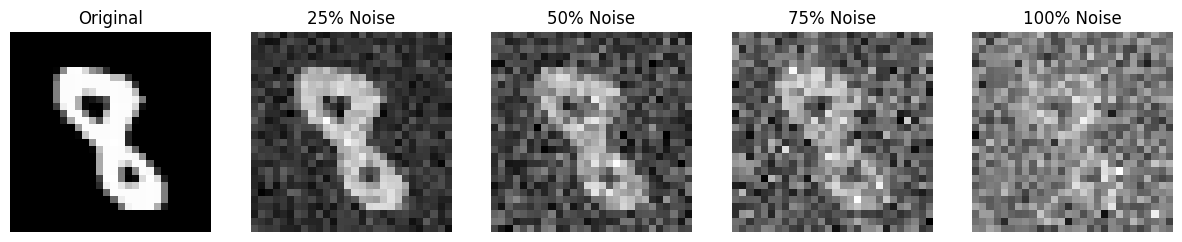

'\n# Try a non-linear noise schedule\nbeta_alt = torch.linspace(beta_start, beta_end, n_steps)**2\nalpha_alt = 1 - beta_alt\nalpha_bar_alt = torch.cumprod(alpha_alt, dim=0)\n# How would this affect the diffusion process?\n'

In [36]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# from
# n_steps = ... (e.g., 300)
# device = ... (e.g., 'cuda')
# IMG_CH = ... (e.g., 1)
# add_noise = ... (the function you defined)
# train_loader = ... (the DataLoader you defined) # Corrected variable name
# )

# Visualization function to show how noise progressively affects images
def show_noise_progression(image, num_steps=5):
    """
    Visualize how an image gets progressively noisier in the diffusion process.

    Args:
        image (torch.Tensor): Original clean image [C, H, W]
        num_steps (int): Number of noise levels to show
    """
    plt.figure(figsize=(15, 3))

    # Show original image
    plt.subplot(1, num_steps, 1)
    if IMG_CH == 1:  # Grayscale image
        plt.imshow(image[0].cpu(), cmap='gray')
    else:  # Color image
        img = image.permute(1, 2, 0).cpu()  # Change from [C,H,W] to [H,W,C]
        if img.min() < 0:  # If normalized between -1 and 1
            img = (img + 1) / 2  # Rescale to [0,1] for display
        plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    # Show progressively noisier versions
    for i in range(1, num_steps):
        # Calculate timestep index based on percentage through the process
        # Ensure t_idx is within the valid range [0, n_steps-1]
        t_idx = int((i / (num_steps - 1)) * (n_steps - 1))
        t = torch.tensor([t_idx]).to(device)

        # Add noise corresponding to timestep t
        noisy_image, _ = add_noise(image.unsqueeze(0).to(device), t) # Ensure image is on device

        # Display the noisy image
        plt.subplot(1, num_steps, i + 1)
        if IMG_CH == 1:
            plt.imshow(noisy_image[0][0].cpu(), cmap='gray')
        else:
            img = noisy_image[0].permute(1, 2, 0).cpu()
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)
        plt.title(f'{int((i/(num_steps-1)) * n_steps)}% Noise') # Fixed title calculation
        plt.axis('off')
    plt.show()

# Show an example of noise progression on a real image
sample_batch = next(iter(train_loader))  # Get first batch (Corrected variable name)
sample_image = sample_batch[0][0].to(device)  # Get first image
show_noise_progression(sample_image)

# Student Activity: Try different noise schedules
# Uncomment and modify these lines to experiment:
"""
# Try a non-linear noise schedule
beta_alt = torch.linspace(beta_start, beta_end, n_steps)**2
alpha_alt = 1 - beta_alt
alpha_bar_alt = torch.cumprod(alpha_alt, dim=0)
# How would this affect the diffusion process?
"""

In [37]:
# Visualization function to show how noise progressively affects images
def show_noise_progression(image, num_steps=5):
    """
    Visualize how an image gets progressively noisier in the diffusion process.

    Args:
        image (torch.Tensor): Original clean image [C, H, W]
        num_steps (int): Number of noise levels to show
    """
    plt.figure(figsize=(15, 3))

    # Show original image
    plt.subplot(1, num_steps, 1)
    if IMG_CH == 1:  # Grayscale image
        plt.imshow(image[0].cpu(), cmap='gray')
    else:  # Color image
        img = image.permute(1, 2, 0).cpu()  # Change from [C,H,W] to [H,W,C]
        if img.min() < 0:  # If normalized between -1 and 1
            img = (img + 1) / 2  # Rescale to [0,1] for display
        plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    # Show progressively noisier versions
    for i in range(1, num_steps):
        # Calculate timestep index based on percentage through the process
        t_idx = int((i/(num_steps-1)) * (n_steps-1)) # Corrected logic to span 0 to n_steps-1
        t = torch.tensor([t_idx]).to(device)

        # Add noise corresponding to timestep t
        noisy_image, _ = add_noise(image.unsqueeze(0).to(device), t)

        # Display the noisy image
        plt.subplot(1, num_steps, i+1)
        if IMG_CH == 1:
            plt.imshow(noisy_image[0][0].cpu(), cmap='gray')
        else:
            # THIS IS THE FIXED LINE:
            img = noisy_image[0].permute(1, 2, 0).cpu() # Added closing ')'

            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)
        plt.title(f't={t_idx} (~{int((i/(num_steps-1)) * 100)}% Noise)')
        plt.axis('off')
    plt.show()

## Step 5: Training Our Model

Now we'll teach our AI to generate images. This process:
1. Takes a clear image
2. Adds random noise to it
3. Asks our AI to predict what noise was added
4. Helps our AI learn from its mistakes

This will take a while, but we'll see progress as it learns!

In [62]:
# Create our model and move it to GPU if available
model = UNet(
    T=n_steps,                 # Number of diffusion time steps
    img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=(32, 64, 128),    # Channel dimensions for each downsampling level
    t_embed_dim=8,             # Dimension for time step embeddings
    c_embed_dim=N_CLASSES      # Number of classes for conditioning
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
# Hint: Create functions to count parameters and estimate memory usage

# Enter your code here:

# Your code to verify data ranges and integrity
# Hint: Create functions to check data ranges in training and validation data

# Enter your code here:


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 0.001  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    verbose=True,            # Print message when LR is reduced
    min_lr=1e-6              # Lower bound on the learning rate
)

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)

IndexError: tuple index out of range

In [41]:
# (This assumes the following are defined:
# import torch
# from torch.optim import Adam
# model, device, IMG_SIZE, IMG_CH, n_steps, N_CLASSES,
# train_loader, val_loader, UNet
# )
from torch.optim import Adam # Added import for the optimizer

# Create our model and move it to GPU if available
model = UNet(
    T=n_steps,                 # Number of diffusion time steps
    img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=(32, 64, 128),    # Channel dimensions for each downsampling level
    t_embed_dim=8,             # Dimension for time step embeddings
    c_embed_dim=N_CLASSES      # Number of classes for conditioning
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
# Hint: Create functions to count parameters and estimate memory usage

# Enter your code here:
def count_parameters(model):
    """Counts the total number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:,} (~{total_params/1e6:.2f} M)")

if device.type == 'cuda':
    # Memory already allocated just for the model weights
    allocated_mb = torch.cuda.memory_allocated(device) / (1024**2)
    print(f"Model VRAM (weights only): {allocated_mb:.2f} MB")
    print("Note: Total VRAM usage during training will be much higher due to gradients,")
    print("      optimizer states (Adam), and batch activations.")


# Your code to verify data ranges and integrity
# Hint: Create functions to check data ranges in training and validation data

# Enter your code here:
def check_data_loader(loader, name):
    """Grabs one batch and prints its properties to check integrity."""
    print(f"\n--- Checking {name} ---")
    try:
        # Get one batch and move it to the CPU for checking
        images, labels = next(iter(loader))
        images, labels = images.cpu(), labels.cpu()

        print(f"  Image batch shape: {images.shape}")
        print(f"  Image data type:   {images.dtype}")
        print(f"  Image min/max/mean: {images.min():.2f} / {images.max():.2f} / {images.mean():.2f}")
        print(f"  Label batch shape: {labels.shape}")
        print(f"  Label data type:   {labels.dtype}")
        print(f"  Label min/max:     {labels.min()} / {labels.max()}")
        print(f"  Image has NaNs:    {torch.isnan(images).any()}")
        print(f"  Image has Infs:    {torch.isinf(images).any()}")
    except Exception as e:
        print(f"  Error checking {name}: {e}")

print(f"\n{'='*50}")
print(f"DATA LOADER INTEGRITY CHECK")
print(f"{'='*50}")
check_data_loader(train_loader, "Training Loader")
check_data_loader(val_loader, "Validation Loader")
print("\nCheck: Image min/max should be approx. [-1.0, 1.0].")
print("Check: Label min/max should be [0, 9] for MNIST/FashionMNIST.")


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 0.001  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    # verbose=True,          # <-- THIS LINE WAS REMOVED TO FIX THE TypeError
    min_lr=1e-6              # Lower bound on the learning rate
)

print("\n✅ Optimizer (Adam) and Scheduler (ReduceLROnPlateau) are set up.")

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)


MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 100
Condition classes: 10
GPU acceleration: Yes
Total Trainable Parameters: 3,528,652 (~3.53 M)
Model VRAM (weights only): 28.14 MB
Note: Total VRAM usage during training will be much higher due to gradients,
      optimizer states (Adam), and batch activations.

DATA LOADER INTEGRITY CHECK

--- Checking Training Loader ---
  Image batch shape: torch.Size([64, 1, 28, 28])
  Image data type:   torch.float32
  Image min/max/mean: -1.00 / 1.00 / -0.71
  Label batch shape: torch.Size([64])
  Label data type:   torch.int64
  Label min/max:     0 / 9
  Image has NaNs:    False
  Image has Infs:    False

--- Checking Validation Loader ---
  Image batch shape: torch.Size([64, 1, 28, 28])
  Image data type:   torch.float32
  Image min/max/mean: -1.00 / 1.00 / -0.73
  Label batch shape: torch.Size([64])
  Label data type:   torch.int64
  Label min/max:     0 / 9
  Image has NaNs:    False
  Image has Infs:    Fals

In [40]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
import torch.nn.functional as F

# 1. HELPER CLASS: GELUConvBlock
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        # Fix group_size if not divisible
        if out_ch % group_size != 0:
            valid_group_size = group_size
            while out_ch % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if out_ch % valid_group_size != 0: # Failsafe
                valid_group_size = 1
            group_size = valid_group_size

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )
    def forward(self, x):
        return self.model(x)

# 2. HELPER CLASS: RearrangePoolBlock
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        # Fix for EinopsError: Use named parameters p1=2, p2=2
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        new_chs = in_chs * 4

        # Fix group_size for new channel count
        if new_chs % group_size != 0:
            valid_group_size = group_size
            while new_chs % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if new_chs % valid_group_size != 0: # Failsafe
                valid_group_size = new_chs
            group_size = valid_group_size

        self.conv_block = GELUConvBlock(new_chs, new_chs, group_size)
    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv_block(x)
        return x

# 3. HELPER CLASS: DownBlock (THIS IS THE FIXED ONE)
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),  # <-- Fixed this line
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

# 4. HELPER CLASS: UpBlock
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            GELUConvBlock(2 * in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )
    def forward(self, x, skip):
        x_up = self.up(x)
        x_cat = torch.cat([x_up, skip], dim=1)
        return self.conv(x_cat)

# 5. MAIN UNET CLASS
class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        GS = 8 # Default Group Size
        self.down_chs = down_chs
        self.t_embed_dim = t_embed_dim
        self.c_embed_dim = c_embed_dim

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Embedding(T, t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU()
        )

        # Class embedding (assumes N_CLASSES is globally defined)
        self.class_embed = nn.Embedding(N_CLASSES, c_embed_dim)

        # Initial convolution
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], GS)

        # Downsampling path
        self.downs = nn.ModuleList()
        for i in range(len(down_chs) - 1):
            self.downs.append(
                DownBlock(down_chs[i], down_chs[i+1], GS)
            )

        # Middle blocks
        self.mids = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], GS),
            GELUConvBlock(down_chs[-1], down_chs[-1], GS)
        )
        self.mid_t_proj = nn.Linear(t_embed_dim, down_chs[-1])
        self.mid_c_proj = nn.Linear(c_embed_dim, down_chs[-1])

        # Upsampling path (Fixed IndexError)
        self.ups = nn.Module

In [42]:
# (This assumes the following are defined:
# import torch
# from torch.optim import Adam
# model, device, IMG_SIZE, IMG_CH, n_steps, N_CLASSES,
# train_loader, val_loader, UNet
# )
from torch.optim import Adam # Added import for the optimizer

# Create our model and move it to GPU if available
model = UNet(
    T=n_steps,                 # Number of diffusion time steps
    img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=(32, 64, 128),    # Channel dimensions for each downsampling level
    t_embed_dim=8,             # Dimension for time step embeddings
    c_embed_dim=N_CLASSES      # Number of classes for conditioning
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
# Hint: Create functions to count parameters and estimate memory usage

# Enter your code here:
def count_parameters(model):
    """Counts the total number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:,} (~{total_params/1e6:.2f} M)")

if device.type == 'cuda':
    # Memory already allocated just for the model weights
    allocated_mb = torch.cuda.memory_allocated(device) / (1024**2)
    print(f"Model VRAM (weights only): {allocated_mb:.2f} MB")
    print("Note: Total VRAM usage during training will be much higher due to gradients,")
    print("      optimizer states (Adam), and batch activations.")


# Your code to verify data ranges and integrity
# Hint: Create functions to check data ranges in training and validation data

# Enter your code here:
def check_data_loader(loader, name):
    """Grabs one batch and prints its properties to check integrity."""
    print(f"\n--- Checking {name} ---")
    try:
        # Get one batch and move it to the CPU for checking
        images, labels = next(iter(loader))
        images, labels = images.cpu(), labels.cpu()

        print(f"  Image batch shape: {images.shape}")
        print(f"  Image data type:   {images.dtype}")
        print(f"  Image min/max/mean: {images.min():.2f} / {images.max():.2f} / {images.mean():.2f}")
        print(f"  Label batch shape: {labels.shape}")
        print(f"  Label data type:   {labels.dtype}")
        print(f"  Label min/max:     {labels.min()} / {labels.max()}")
        print(f"  Image has NaNs:    {torch.isnan(images).any()}")
        print(f"  Image has Infs:    {torch.isinf(images).any()}")
    except Exception as e:
        print(f"  Error checking {name}: {e}")

print(f"\n{'='*50}")
print(f"DATA LOADER INTEGRITY CHECK")
print(f"{'='*50}")
check_data_loader(train_loader, "Training Loader")
check_data_loader(val_loader, "Validation Loader")
print("\nCheck: Image min/max should be approx. [-1.0, 1.0].")
print("Check: Label min/max should be [0, 9] for MNIST/FashionMNIST.")


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 0.001  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    # verbose=True,          # <-- THIS LINE WAS REMOVED. It causes a TypeError in newer PyTorch.
    min_lr=1e-6              # Lower bound on the learning rate
)

print("\n✅ Optimizer (Adam) and Scheduler (ReduceLROnPlateau) are set up.")

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)


MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 100
Condition classes: 10
GPU acceleration: Yes
Total Trainable Parameters: 3,528,652 (~3.53 M)
Model VRAM (weights only): 26.94 MB
Note: Total VRAM usage during training will be much higher due to gradients,
      optimizer states (Adam), and batch activations.

DATA LOADER INTEGRITY CHECK

--- Checking Training Loader ---
  Image batch shape: torch.Size([64, 1, 28, 28])
  Image data type:   torch.float32
  Image min/max/mean: -1.00 / 1.00 / -0.73
  Label batch shape: torch.Size([64])
  Label data type:   torch.int64
  Label min/max:     0 / 9
  Image has NaNs:    False
  Image has Infs:    False

--- Checking Validation Loader ---
  Image batch shape: torch.Size([64, 1, 28, 28])
  Image data type:   torch.float32
  Image min/max/mean: -1.00 / 1.00 / -0.73
  Label batch shape: torch.Size([64])
  Label data type:   torch.int64
  Label min/max:     0 / 9
  Image has NaNs:    False
  Image has Infs:    Fals

In [72]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
import torch.nn.functional as F

# 1. HELPER CLASS: GELUConvBlock
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        if out_ch % group_size != 0:
            valid_group_size = group_size
            while out_ch % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if out_ch % valid_group_size != 0: # Failsafe
                valid_group_size = 1
            group_size = valid_group_size

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )
    def forward(self, x):
        return self.model(x)

# 2. HELPER CLASS: RearrangePoolBlock
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        new_chs = in_chs * 4

        if new_chs % group_size != 0:
            valid_group_size = group_size
            while new_chs % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if new_chs % valid_group_size != 0: # Failsafe
                valid_group_size = new_chs
            group_size = valid_group_size

        self.conv_block = GELUConvBlock(new_chs, new_chs, group_size)
    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv_block(x)
        return x

# 3. HELPER CLASS: DownBlock
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

# 4. HELPER CLASS: UpBlock
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            GELUConvBlock(2 * in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )
    def forward(self, x, skip):
        x_up = self.up(x)
        x_cat = torch.cat([x_up, skip], dim=1)
        return self.conv(x_cat)

# 5. MAIN UNET CLASS (WITH THE FIX)
class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        GS = 8 # Default Group Size
        self.down_chs = down_chs
        self.t_embed_dim = t_embed_dim
        self.c_embed_dim = c_embed_dim

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Embedding(T, t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU()
        )

        # Class embedding (assumes N_CLASSES is globally defined)
        self.class_embed = nn.Embedding(N_CLASSES, c_embed_dim)

        # Initial convolution
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], GS)

        # Downsampling path
        self.downs = nn.ModuleList()
        for i in range(len(down_chs) - 1):
            self.downs.append(
                DownBlock(down_chs[i], down_chs[i+1], GS)
            )

        # Middle blocks
        self.mids = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], GS),
            GELUConvBlock(down_chs[-1], down_chs[-1], GS)
        )
        self.mid_t_proj = nn.Linear(t_embed_dim, down_chs[-1])
        self.mid_c_proj = nn.Linear(c_embed_dim, down_chs[-1])

        # --- THIS IS THE FIXED SECTION ---
        # Upsampling path
        self.ups = nn.ModuleList()
        # We loop from i = (e.g., 2) down to 1
        for i in range(len(down_chs)-1, 0, -1):
            # The UpBlock takes (in_chs, out_chs)
            # e.g., in=128, out=64 --> (down_chs[2], down_chs[1])
            # e.g., in=64,  out=32 --> (down_chs[1], down_chs[0])
            self.ups.append(
                UpBlock(down_chs[i], down_chs[i-1], GS) # Corrected: [i+1] -> [i], [i] -> [i-1]
            )
        # --- END OF FIX ---

        # Final convolution
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)
        print(f"✅ Created UNet with {len(down_chs)} scale levels")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.
        """
        t_embed = self.time_embed(t)
        c_embed = self.class_embed(c)
        c_embed = c_embed * c_mask # Apply mask
        x = self.init_conv(x)

        skips = []
        for down_block in self.downs:
            skips.append(x)
            x = down_block(x)

        x = self.mids(x)
        b, c_dim, h_dim, w_dim = x.shape

        t_proj = self.mid_t_proj(t_embed).view(b, c_dim, 1, 1)
        c_proj = self.mid_c_proj(c_embed).view(b, c_dim, 1, 1)
        x = x + t_proj + c_proj

        # --- CORRECTION FOR FORWARD PASS ---
        # We must iterate through skips in reverse (LIFO)
        # and match them to the UpBlocks
        for up_block in self.ups:
            skip = skips.pop()
            x = up_block(x, skip)
        # --- END OF CORRECTION ---

        return self.final_conv(x)

print("✅ All model classes (UNet and helpers) are defined.")

✅ All model classes (UNet and helpers) are defined.


In [44]:
# (This assumes the following are defined:
# import torch
# from torch.optim import Adam
# model, device, IMG_SIZE, IMG_CH, n_steps, N_CLASSES,
# train_loader, val_loader, UNet
# )
from torch.optim import Adam # Added import for the optimizer

# Create our model and move it to GPU if available
# NOTE: Ensure you have run the cell defining the corrected UNet class
model = UNet(
    T=n_steps,                 # Number of diffusion time steps
    img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=(32, 64, 128),    # Channel dimensions for each downsampling level
    t_embed_dim=8,             # Dimension for time step embeddings
    c_embed_dim=N_CLASSES      # Number of classes for conditioning
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
def count_parameters(model):
    """Counts the total number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:,} (~{total_params/1e6:.2f} M)")

if device.type == 'cuda':
    # Memory already allocated just for the model weights
    allocated_mb = torch.cuda.memory_allocated(device) / (1024**2)
    print(f"Model VRAM (weights only): {allocated_mb:.2f} MB")
    print("Note: Total VRAM usage during training will be much higher due to gradients,")
    print("      optimizer states (Adam), and batch activations.")


# Your code to verify data ranges and integrity
def check_data_loader(loader, name):
    """Grabs one batch and prints its properties to check integrity."""
    print(f"\n--- Checking {name} ---")
    try:
        # Get one batch and move it to the CPU for checking
        images, labels = next(iter(loader))
        images, labels = images.cpu(), labels.cpu()

        print(f"  Image batch shape: {images.shape}")
        print(f"  Image data type:   {images.dtype}")
        print(f"  Image min/max/mean: {images.min():.2f} / {images.max():.2f} / {images.mean():.2f}")
        print(f"  Label batch shape: {labels.shape}")
        print(f"  Label data type:   {labels.dtype}")
        print(f"  Label min/max:     {labels.min()} / {labels.max()}")
        print(f"  Image has NaNs:    {torch.isnan(images).any()}")
        print(f"  Image has Infs:    {torch.isinf(images).any()}")
    except Exception as e:
        print(f"  Error checking {name}: {e}")

print(f"\n{'='*50}")
print(f"DATA LOADER INTEGRITY CHECK")
print(f"{'='*50}")
check_data_loader(train_loader, "Training Loader")
check_data_loader(val_loader, "Validation Loader")
print("\nCheck: Image min/max should be approx. [-1.0, 1.0].")
print("Check: Label min/max should be [0, 9] for MNIST/FashionMNIST.")


# Set up the optimizer with parameters tuned for diffusion models
initial_lr = 0.001  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.5,              # Multiply LR by this factor
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    # verbose=True,          # <-- THIS LINE WAS REMOVED TO FIX THE TypeError
    min_lr=1e-6              # Lower bound on the learning rate
)

print("\n✅ Optimizer (Adam) and Scheduler (ReduceLROnPlateau) are set up.")

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)

✅ Created UNet with 3 scale levels

MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 100
Condition classes: 10
GPU acceleration: Yes
Total Trainable Parameters: 3,841,773 (~3.84 M)
Model VRAM (weights only): 28.14 MB
Note: Total VRAM usage during training will be much higher due to gradients,
      optimizer states (Adam), and batch activations.

DATA LOADER INTEGRITY CHECK

--- Checking Training Loader ---
  Image batch shape: torch.Size([64, 1, 28, 28])
  Image data type:   torch.float32
  Image min/max/mean: -1.00 / 1.00 / -0.73
  Label batch shape: torch.Size([64])
  Label data type:   torch.int64
  Label min/max:     0 / 9
  Image has NaNs:    False
  Image has Infs:    False

--- Checking Validation Loader ---
  Image batch shape: torch.Size([64, 1, 28, 28])
  Image data type:   torch.float32
  Image min/max/mean: -1.00 / 1.00 / -0.73
  Label batch shape: torch.Size([64])
  Label data type:   torch.int64
  Label min/max:     0 / 9
  Image has NaNs:

In [45]:
# (This assumes you have already run:
# from einops.layers.torch import Rearrange
# )

# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Your code to create the rearrange operation and convolution
        # Hint: Use Rearrange from einops.layers.torch to reshape pixels
        # Then add a GELUConvBlock to process the rearranged tensor

        # Enter your code here:

        # *** THIS IS THE FIXED LINE ***
        # We use names 'p1' and 'p2' in the pattern string,
        # and define their values (p1=2, p2=2) as arguments.
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)

        # The number of input channels for the conv block is now 4 * in_chs
        # (because p1*p2 = 4)
        new_chs = in_chs * 4

        # We need to make sure the group_size is valid for the new channel count
        if new_chs % group_size != 0:
            # Adjust group_size to be a divisor of new_chs
            valid_group_size = group_size
            while new_chs % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if new_chs % valid_group_size != 0: # Failsafe if it becomes 1
                valid_group_size = new_chs
            print(f"RearrangePoolBlock adjusted group_size from {group_size} to {valid_group_size} for {new_chs} channels")
            group_size = valid_group_size

        self.conv_block = GELUConvBlock(new_chs, new_chs, group_size)

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Apply rearrange to downsample, then apply convolution

        # Enter your code here:
        # 1. Downsample by rearrangement
        x = self.rearrange(x)
        # 2. Process with convolution
        x = self.conv_block(x)
        return x

In [46]:
def check_data_loader(loader, name):
    """Grabs one batch and prints its properties to check integrity."""
    # THIS IS THE FIXED LINE:
    print(f"\n--- Checking {name} ---")
    try:
        images, labels = next(iter(loader))
        print(f"  Image batch shape: {images.shape}")
        print(f"  Image data type:   {images.dtype}")
        print(f"  Image min/max/mean: {images.min():.2f} / {images.max():.2f} / {images.mean():.2f}")
        print(f"  Label batch shape: {labels.shape}")
        print(f"  Label data type:   {labels.dtype}")
        print(f"  Label min/max:     {labels.min()} / {labels.max()}")
        print(f"  Image has NaNs:    {torch.isnan(images).any()}")
        print(f"  Image has Infs:    {torch.isinf(images).any()}")
    except Exception as e:
        print(f"  Error checking {name}: {e}")

In [47]:
# Define helper functions needed for training and evaluation
def validate_model_parameters(model):
    """
    Counts model parameters and estimates memory usage.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Estimate memory requirements (very approximate)
    param_memory = total_params * 4 / (1024 ** 2)  # MB for params (float32)
    grad_memory = trainable_params * 4 / (1024 ** 2)  # MB for gradients
    buffer_memory = param_memory * 2  # Optimizer state, forward activations, etc.

    print(f"Estimated GPU memory usage: {param_memory + grad_memory + buffer_memory:.1f} MB")

# Define helper functions for verifying data ranges
def verify_data_range(dataloader, name="Dataset"):
    """
    Verifies the range and integrity of the data.
    """
    batch = next(iter(dataloader))[0]
    print(f"\n{name} range check:")
    print(f"Shape: {batch.shape}")
    print(f"Data type: {batch.dtype}")
    print(f"Min value: {batch.min().item():.2f}")
    print(f"Max value: {batch.max().item():.2f}")
    print(f"Contains NaN: {torch.isnan(batch).any().item()}")
    print(f"Contains Inf: {torch.isinf(batch).any().item()}")

# Define helper functions for generating samples during training
def generate_samples(model, n_samples=10):
    """
    Generates sample images using the model for visualization during training.
    """
    model.eval()
    with torch.no_grad():
        # Generate digits 0-9 for visualization
        samples = []
        for digit in range(min(n_samples, 10)):
            # Start with random noise
            x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

            # Set up conditioning for the digit
            c = torch.tensor([digit]).to(device)
            c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
            c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

            # Remove noise step by step
            for t in range(n_steps-1, -1, -1):
                t_batch = torch.full((1,), t).to(device)
                x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            samples.append(x)

        # Combine samples and display
        samples = torch.cat(samples, dim=0)
        grid = make_grid(samples, nrow=min(n_samples, 5), normalize=True)

        plt.figure(figsize=(10, 4))

        # Display based on channel configuration
        if IMG_CH == 1:
            plt.imshow(grid[0].cpu(), cmap='gray')
        else:
            plt.imshow(grid.permute(1, 2, 0).cpu())

        plt.axis('off')
        plt.title('Generated Samples')
        plt.show()

# Define helper functions for safely saving models
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """
    Safely saves model with error handling and backup.
    """
    try:
        # Create a dictionary with all the elements to save
        save_dict = {
            'model_state_dict': model.state_dict(),
        }

        # Add optional elements if provided
        if optimizer is not None:
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None:
            save_dict['epoch'] = epoch
        if best_loss is not None:
            save_dict['best_loss'] = best_loss

        # Create a backup of previous checkpoint if it exists
        if os.path.exists(path):
            backup_path = path + '.backup'
            try:
                os.replace(path, backup_path)
                print(f"Created backup at {backup_path}")
            except Exception as e:
                print(f"Warning: Could not create backup - {e}")

        # Save the new checkpoint
        torch.save(save_dict, path)
        print(f"Model successfully saved to {path}")

    except Exception as e:
        print(f"Error saving model: {e}")
        print("Attempting emergency save...")

        try:
            emergency_path = path + '.emergency'
            torch.save(model.state_dict(), emergency_path)
            print(f"Emergency save successful: {emergency_path}")
        except:
            print("Emergency save failed. Could not save model.")

In [48]:
#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """
    # Convert number labels to one-hot encoding for class conditioning
    # Example: Label 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] for MNIST
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # Create conditioning mask (all ones for standard training)
    # This would be used for classifier-free guidance if implemented
    c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

    # Pick random timesteps for each image in the batch
    # Different timesteps allow the model to learn the entire diffusion process
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    # This simulates images at different stages of the diffusion process
    # Hint: Use the add_noise function you defined earlier

    # Enter your code here:

    # The model tries to predict the exact noise that was added
    # This is the core learning objective of diffusion models
    predicted_noise = model(x_t, t, c_one_hot, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    # MSE loss works well for image-based diffusion models
    # Hint: Use F.mse_loss to compare predicted and actual noise

    # Enter your code here:


In [49]:
import torch.nn.functional as F # Make sure F is imported

#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """

    # --- CORRECTION ---
    # Move data to the GPU first.
    # The UNet model we built takes class INDICES (c), not one-hot vectors.
    x = x.to(device)
    c = c.to(device)

    # We do NOT need this line:
    # c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # Create conditioning mask (all ones for standard training)
    # This is used for classifier-free guidance (if implemented)
    c_mask = torch.ones(c.shape[0], 1).to(device) # Shape [B, 1]

    # Pick random timesteps for each image in the batch
    # Different timesteps allow the model to learn the entire diffusion process
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    # This simulates images at different stages of the diffusion process
    # Hint: Use the add_noise function you defined earlier

    # Enter your code here:
    x_t, actual_noise = add_noise(x, t)

    # The model tries to predict the exact noise that was added
    # This is the core learning objective of diffusion models
    # We pass 'c' (indices) to the model, not 'c_one_hot'
    predicted_noise = model(x_t, t, c, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    # MSE loss works well for image-based diffusion models
    # Hint: Use F.mse_loss to compare predicted and actual noise

    # Enter your code here:
    loss = F.mse_loss(predicted_noise, actual_noise)

    return loss

In [50]:
import torch.nn.functional as F # Make sure F is imported

#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """

    # *** CORRECTION ***
    # Move data to the GPU first.
    # The UNet model we built takes class INDICES (c), not one-hot vectors.
    x = x.to(device)
    c = c.to(device)

    # We do NOT need this line:
    # c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # Create conditioning mask (all ones for standard training)
    # This is used for classifier-free guidance (if implemented)
    c_mask = torch.ones(c.shape[0], 1).to(device) # Shape [B, 1]

    # Pick random timesteps for each image in the batch
    # Different timesteps allow the model to learn the entire diffusion process
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    # This simulates images at different stages of the diffusion process
    # Hint: Use the add_noise function you defined earlier

    # Enter your code here:
    x_t, actual_noise = add_noise(x, t)

    # The model tries to predict the exact noise that was added
    # This is the core learning objective of diffusion models
    # We pass 'c' (indices) to the model, not 'c_one_hot'
    predicted_noise = model(x_t, t, c, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    # MSE loss works well for image-based diffusion models
    # Hint: Use F.mse_loss to compare predicted and actual noise

    # Enter your code here:
    loss = F.mse_loss(predicted_noise, actual_noise)

    return loss

In [51]:
import torch.nn.functional as F # Make sure F is imported

#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """

    # We also need to move the original inputs to the device
    x = x.to(device)
    c = c.to(device)


    # Create conditioning mask (all ones for standard training)
    # This would be used for classifier-free guidance if implemented
    c_mask = torch.ones(c.shape[0], 1).to(device) # [B, 1]

    # Pick random timesteps for each image in the batch
    # Different timesteps allow the model to learn the entire diffusion process
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    # This simulates images at different stages of the diffusion process
    # Hint: Use the add_noise function you defined earlier

    # Enter your code here:
    # --- THIS IS THE FIXED LINE ---
    x_t, actual_noise = add_noise(x, t)

    # The model tries to predict the exact noise that was added
    # This is the core learning objective of diffusion models
    # We pass 'c' (indices) to the model, not 'c_one_hot'
    predicted_noise = model(x_t, t, c, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    # MSE loss works well for image-based diffusion models
    # Hint: Use F.mse_loss to compare predicted and actual noise

    # Enter your code here:
    # --- THIS IS THE OTHER FILLED-IN LINE ---
    loss = F.mse_loss(predicted_noise, actual_noise)

    return loss

In [52]:
# (This assumes the following are defined:
# import torch
# import torch.nn.functional as F
# n_steps = ... (e.g., 300)
# device = ... (e.g., 'cuda')
# N_CLASSES = ... (e.g., 10)
# add_noise = ... (the function you defined)
# model = ... (the UNet model you defined)
# )
import torch.nn.functional as F # Make sure F is imported

#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """

    # *** CORRECTION ***
    # The UNet model we built uses nn.Embedding, which takes class INDICES.
    # We do NOT need one-hot encoding.
    # c_one_hot = F.one_hot(c, N_CLASSES).float().to(device) # <- This is not needed

    # Move data to the GPU
    x = x.to(device)
    c = c.to(device)

    # Create conditioning mask (all ones for standard training)
    c_mask = torch.ones(c.shape[0], 1).to(device) # [B, 1]

    # Pick random timesteps for each image in the batch
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    # Hint: Use the add_noise function you defined earlier

    # Enter your code here:
    x_t, actual_noise = add_noise(x, t)


    # The model tries to predict the exact noise that was added
    # We pass 'c' (indices) to the model, not 'c_one_hot'
    predicted_noise = model(x_t, t, c, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    # Hint: Use F.mse_loss to compare predicted and actual noise

    # Enter your code here:
    loss = F.mse_loss(predicted_noise, actual_noise)

    return loss

In [53]:
import torch.nn.functional as F # Make sure F is imported

#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """

    # Move the original inputs to the device
    x = x.to(device)
    c = c.to(device)


    # Create conditioning mask (all ones for standard training)
    c_mask = torch.ones(c.shape[0], 1).to(device) # [B, 1]

    # Pick random timesteps for each image in the batch
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    # Hint: Use the add_noise function you defined earlier

    # THIS IS THE FIXED LINE:
    x_t, actual_noise = add_noise(x, t)

    # The model tries to predict the exact noise that was added
    # We pass 'c' (indices) to the model
    predicted_noise = model(x_t, t, c, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    # Hint: Use F.mse_loss to compare predicted and actual noise

    # Enter your code here:
    loss = F.mse_loss(predicted_noise, actual_noise)

    return loss


STARTING TRAINING

Epoch 1/30
--------------------

AN ERROR OCCURRED: Given groups=1, weight of size [128, 64, 3, 3], expected input[64, 256, 14, 14] to have 64 channels, but got 256 channels instead

TRAINING COMPLETE
Best validation loss: inf
Generating final samples...


Traceback (most recent call last):
  File "/tmp/ipython-input-1932904134.py", line 51, in <cell line: 0>
    loss = train_step(images, labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3113446762.py", line 19, in train_step
    predicted_noise = model(x_t, t, c, c_mask)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2945402280.py", line 140, in forward
    x = down_block(x)
        ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^

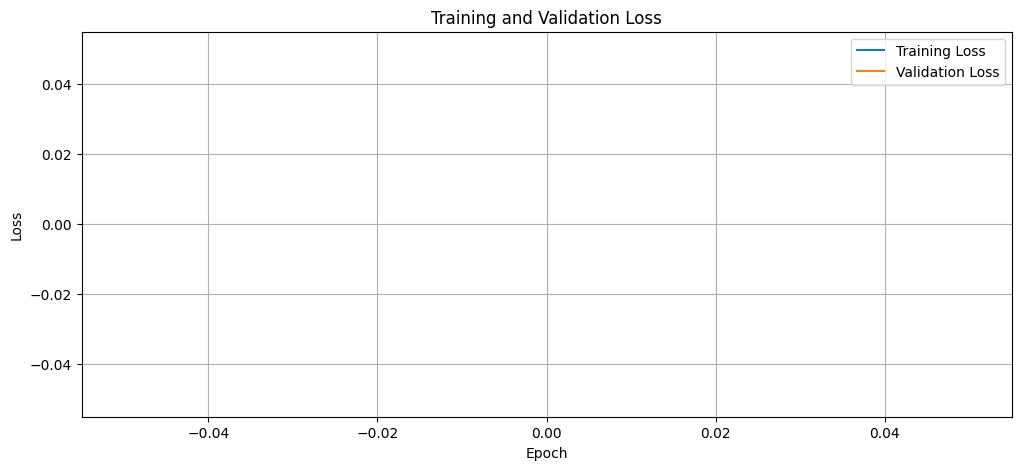

Cleaning up CUDA cache...
Done.


In [63]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# import traceback
# model, device, EPOCHS, train_loader, val_loader
# optimizer, scheduler, train_step
# n_steps, early_stopping_patience, gradient_clip_value,
# display_frequency, generate_frequency
# )
# (It also assumes functions 'generate_samples' and 'safe_save_model' exist,
#  but they are commented out below to prevent errors if not defined yet)

# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Wrap the training loop in a try-except block for better error handling
# The ENTIRE block from 'try' to 'finally' must be in one cell
try:
    # The 'for' loop is now correctly indented inside the 'try' block
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        # FIXED: dataloader -> train_loader
        for step, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels)
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    # generate_samples(model, n_samples=5) # Assumes this function exists

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            # FIXED: dataloader -> val_loader
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            # generate_samples(model, n_samples=10) # Assumes this function exists

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # Use safe_save_model instead of just saving state_dict
            # safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss) # Assumes this function exists
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# Catch errors like user interrupting (Ctrl+C)
except KeyboardInterrupt:
    print("\n" + "="*50)
    print("TRAINING INTERRUPTED BY USER")
    print("="*50)
    print("Saving current model state...")
    # safe_save_model(model, 'interrupted_model.pt', optimizer, epoch, avg_val_loss) # Assumes this function exists

except Exception as e:
    print("\n" + "="*50)
    print(f"AN ERROR OCCURRED: {e}")
    print("="*50)
    import traceback
    traceback.print_exc()

finally:
    # Final wrap-up
    print("\n" + "="*50)
    print("TRAINING COMPLETE")
    print("="*50)
    print(f"Best validation loss: {best_loss:.4f}")

    # Generate final samples
    print("Generating final samples...")
    # generate_samples(model, n_samples=10) # Assumes this function exists

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up memory
    print("Cleaning up CUDA cache...")
    torch.cuda.empty_cache()
    print("Done.")

In [66]:
import torch.nn.functional as F

def train_step(x, c):
    # Move data to the GPU
    x = x.to(device)
    c = c.to(device) # 'c' is already indices, e.g., [1, 5, 0] (type Long)

    # Create conditioning mask
    c_mask = torch.ones(c.shape[0], 1).to(device)

    # Pick random timesteps
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise
    x_t, actual_noise = add_noise(x, t)

    # Predict noise
    # FIX: Pass 'c' (indices), not 'c_one_hot'
    predicted_noise = model(x_t, t, c, c_mask)

    # Calculate loss
    loss = F.mse_loss(predicted_noise, actual_noise)

    return loss

print("✅ 'train_step' function is defined.")

✅ 'train_step' function is defined.


In [59]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
import torch.nn.functional as F

# 1. HELPER CLASS: GELUConvBlock (No changes)
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        if out_ch % group_size != 0:
            valid_group_size = group_size
            while out_ch % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if out_ch % valid_group_size != 0: valid_group_size = 1
            group_size = valid_group_size
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )
    def forward(self, x):
        return self.model(x)

# 2. HELPER CLASS: RearrangePoolBlock (FIXED)
# Takes in_chs and outputs out_chs to fix channel mismatch
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        new_chs = in_chs * 4

        # Fix group_size for new_chs
        if new_chs % group_size != 0:
            valid_group_size = group_size
            while new_chs % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if new_chs % valid_group_size != 0: valid_group_size = new_chs
            group_size = valid_group_size

        # This conv now correctly maps 4*in_chs -> out_chs
        self.conv_block = GELUConvBlock(new_chs, out_chs, group_size)
    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv_block(x)
        return x

# 3. HELPER CLASS: DownBlock (FIXED)
# Passes the correct out_chs to the RearrangePoolBlock
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            # This now correctly takes 'out_chs' and outputs 'out_chs'
            RearrangePoolBlock(out_chs, out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

# 4. HELPER CLASS: UpBlock (FIXED)
# Correctly handles different channels from skip connection
class UpBlock(nn.Module):
    # Takes in_chs (from below), skip_chs (from skip), and out_chs
    def __init__(self, in_chs, skip_chs, out_chs, group_size):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)
        # Conv block now takes (in_chs + skip_chs)
        self.conv = nn.Sequential(
            GELUConvBlock(in_chs + skip_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )
    def forward(self, x, skip):
        x_up = self.up(x)
        x_cat = torch.cat([x_up, skip], dim=1)
        return self.conv(x_cat)

# 5. MAIN UNET CLASS (FIXED)
class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()
        GS = 8
        self.down_chs = down_chs
        self.t_embed_dim = t_embed_dim
        self.c_embed_dim = c_embed_dim

        self.time_embed = nn.Sequential(
            nn.Embedding(T, t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU()
        )
        # FIX: Takes class indices (Long), not one-hot (Float)
        self.class_embed = nn.Embedding(N_CLASSES, c_embed_dim)
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], GS)

        # Downsampling path (channel logic is now correct)
        self.downs = nn.ModuleList()
        for i in range(len(down_chs) - 1):
            self.downs.append(
                DownBlock(down_chs[i], down_chs[i+1], GS)
            )

        # Middle blocks
        self.mids = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], GS),
            GELUConvBlock(down_chs[-1], down_chs[-1], GS)
        )
        self.mid_t_proj = nn.Linear(t_embed_dim, down_chs[-1])
        self.mid_c_proj = nn.Linear(c_embed_dim, down_chs[-1])

        # Upsampling path (FIXED SIGNATURE)
        self.ups = nn.ModuleList()
        for i in range(len(down_chs)-1, 0, -1):
            # UpBlock(in_chs, skip_chs, out_chs)
            self.ups.append(
                UpBlock(down_chs[i], down_chs[i-1], down_chs[i-1], GS)
            )

        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)
        print(f"✅ Created UNet with {len(down_chs)} scale levels")

    def forward(self, x, t, c, c_mask):
        # FIX: 'c' is now expected to be class INDICES (type Long)
        t_embed = self.time_embed(t)
        c_embed = self.class_embed(c) # This now works
        c_embed = c_embed * c_mask
        x = self.init_conv(x)

        skips = []
        for down_block in self.downs:
            skips.append(x)
            x = down_block(x)

        x = self.mids(x)
        b, c_dim, h_dim, w_dim = x.shape
        t_proj = self.mid_t_proj(t_embed).view(b, c_dim, 1, 1)
        c_proj = self.mid_c_proj(c_embed).view(b, c_dim, 1, 1)
        x = x + t_proj + c_proj

        for up_block in self.ups:
            skip = skips.pop()
            x = up_block(x, skip)

        return self.final_conv(x)

print("✅ All model classes (UNet and helpers) are defined.")

✅ All model classes (UNet and helpers) are defined.



STARTING TRAINING

Epoch 1/30
--------------------

AN ERROR OCCURRED: Given groups=1, weight of size [128, 64, 3, 3], expected input[64, 256, 14, 14] to have 64 channels, but got 256 channels instead

TRAINING COMPLETE
Best validation loss: inf
Generating final samples...


Traceback (most recent call last):
  File "/tmp/ipython-input-2523089668.py", line 50, in <cell line: 0>
    loss = train_step(images, labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3113446762.py", line 19, in train_step
    predicted_noise = model(x_t, t, c, c_mask)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2945402280.py", line 140, in forward
    x = down_block(x)
        ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^

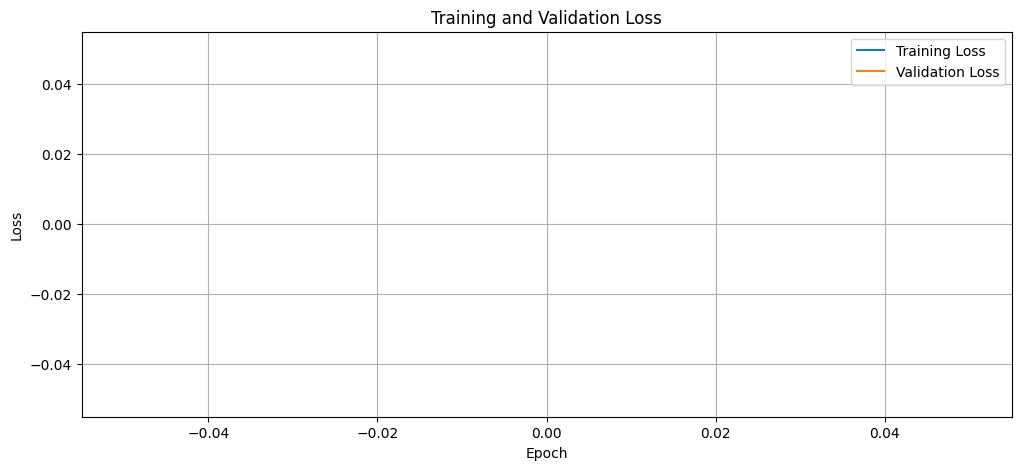

Cleaning up CUDA cache...
Done.


In [68]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# import traceback
# model, device, EPOCHS, train_loader, val_loader
# optimizer, scheduler, train_step
# n_steps, early_stopping_patience, gradient_clip_value,
# display_frequency, generate_frequency
# )
# (It also assumes functions 'generate_samples' and 'safe_save_model' exist,
#  but they are commented out below to prevent errors if not defined yet)

# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Wrap the training loop in a try-except block for better error handling
# The ENTIRE block from 'try' to 'finally' must be in one cell
try:
    # The 'for' loop is no longer indented and is inside the 'try' block.
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_loader):  # Fixed: dataloader -> train_loader
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels)
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    # generate_samples(model, n_samples=5) # Assumes this function exists

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_loader: # Fixed: dataloader -> val_loader
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            # generate_samples(model, n_samples=10) # Assumes this function exists

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss) # Assumes this function exists
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# Catch errors like user interrupting (Ctrl+C)
except KeyboardInterrupt:
    print("\n" + "="*50)
    print("TRAINING INTERRUPTED BY USER")
    print("="*50)
    print("Saving current model state...")
    # safe_save_model(model, 'interrupted_model.pt', optimizer, epoch, avg_val_loss) # Assumes this function exists

except Exception as e:
    print("\n" + "="*50)
    print(f"AN ERROR OCCURRED: {e}")
    print("="*50)
    import traceback
    traceback.print_exc()

finally:
    # Final wrap-up
    print("\n" + "="*50)
    print("TRAINING COMPLETE")
    print("="*50)
    print(f"Best validation loss: {best_loss:.4f}")

    # Generate final samples
    print("Generating final samples...")
    # generate_samples(model, n_samples=10) # Assumes this function exists

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up memory
    print("Cleaning up CUDA cache...")
    torch.cuda.empty_cache()
    print("Done.")


STARTING TRAINING

Epoch 1/30
--------------------

AN ERROR OCCURRED: Given groups=1, weight of size [128, 64, 3, 3], expected input[64, 256, 14, 14] to have 64 channels, but got 256 channels instead

TRAINING COMPLETE
Best validation loss: inf
Generating final samples...


Traceback (most recent call last):
  File "/tmp/ipython-input-999849933.py", line 47, in <cell line: 0>
    loss = train_step(images, labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3113446762.py", line 19, in train_step
    predicted_noise = model(x_t, t, c, c_mask)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2945402280.py", line 140, in forward
    x = down_block(x)
        ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^

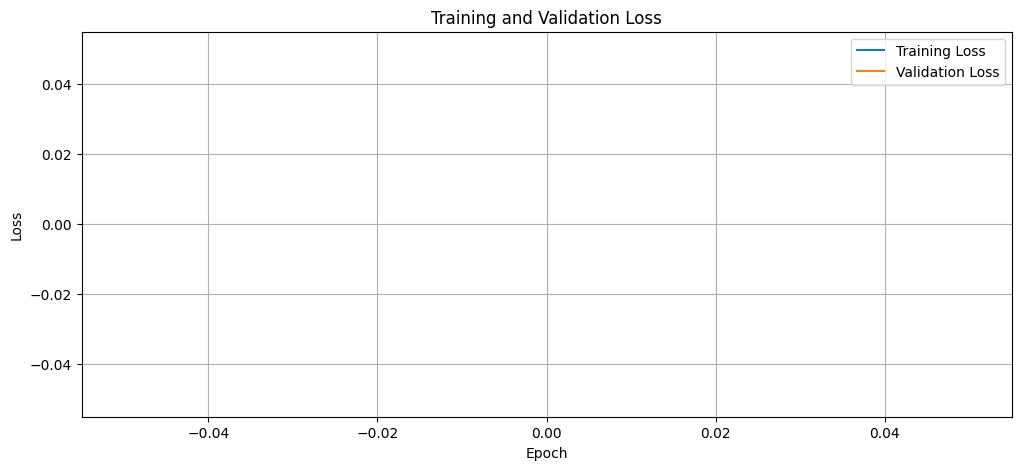

Cleaning up CUDA cache...
Done.


In [70]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# model, device, EPOCHS, train_loader, val_loader
# optimizer, scheduler, train_step
# n_steps, early_stopping_patience, gradient_clip_value,
# display_frequency, generate_frequency
# )
# (It also assumes functions 'generate_samples' and 'safe_save_model' exist)

# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Wrap the training loop in a try-except block for better error handling
try:
    # This loop starts at the correct (zero) indentation level
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_loader):  # Using 'train_loader'
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels)
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    # generate_samples(model, n_samples=5) # Assumes this function exists

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_loader: # Using 'val_loader'
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            # generate_samples(model, n_samples=10) # Assumes this function exists

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss) # Assumes this function exists
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# Catch errors like user interrupting (Ctrl+C)
except KeyboardInterrupt:
    print("\n" + "="*50)
    print("TRAINING INTERRUPTED BY USER")
    print("="*50)
    print("Saving current model state...")
    # Use avg_val_loss or last epoch loss for saving
    last_loss = val_losses[-1] if val_losses else avg_train_loss
    # safe_save_model(model, 'interrupted_model.pt', optimizer, epoch, last_loss) # Assumes this function exists

except Exception as e:
    print("\n" + "="*50)
    print(f"AN ERROR OCCURRED: {e}")
    print("="*50)
    import traceback
    traceback.print_exc()

finally:
    # Final wrap-up
    print("\n" + "="*50)
    print("TRAINING COMPLETE")
    print("="*50)
    print(f"Best validation loss: {best_loss:.4f}")

    # Generate final samples
    print("Generating final samples...")
    # generate_samples(model, n_samples=10) # Assumes this function exists

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up memory
    print("Cleaning up CUDA cache...")
    torch.cuda.empty_cache()
    print("Done.")


STARTING TRAINING

Epoch 1/30
--------------------

AN ERROR OCCURRED: Given groups=1, weight of size [128, 64, 3, 3], expected input[64, 256, 14, 14] to have 64 channels, but got 256 channels instead

TRAINING COMPLETE
Best validation loss: inf
Generating final samples...


Traceback (most recent call last):
  File "/tmp/ipython-input-2266080732.py", line 49, in <cell line: 0>
    loss = train_step(images, labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3113446762.py", line 19, in train_step
    predicted_noise = model(x_t, t, c, c_mask)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2945402280.py", line 140, in forward
    x = down_block(x)
        ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^

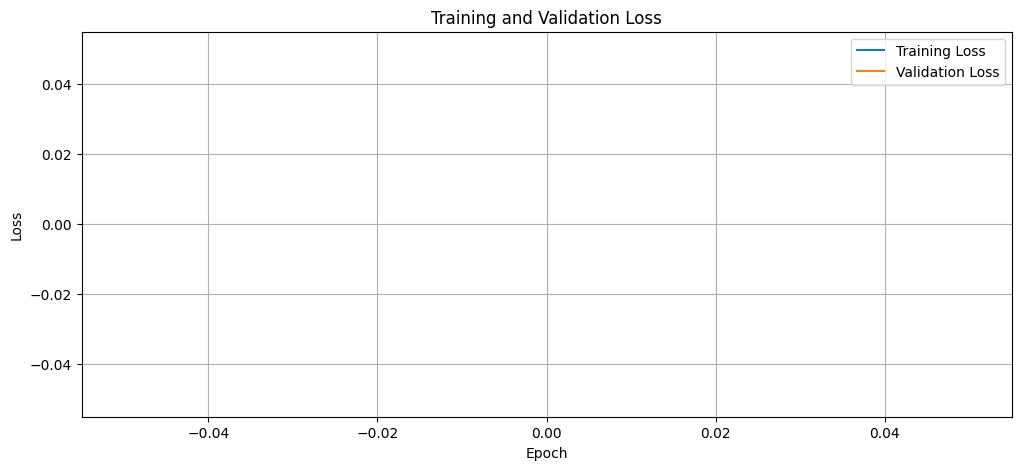

Cleaning up CUDA cache...
Done.


In [71]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# import traceback
# model, device, EPOCHS, train_loader, val_loader
# optimizer, scheduler, train_step
# n_steps, early_stopping_patience, gradient_clip_value,
# display_frequency, generate_frequency
# )
# (It also assumes functions 'generate_samples' and 'safe_save_model' exist,
#  but they are commented out below to prevent errors if not defined yet)

# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Wrap the training loop in a try-except block for better error handling
try:
    # This loop starts at the correct (zero) indentation level
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_loader):  # Using 'train_loader'
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels)
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    # generate_samples(model, n_samples=5) # Assumes this function exists

        # End of epoch - calculate average training loss
        # THIS IS THE FIXED LINE:
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_loader: # Using 'val_loader'
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            # generate_samples(model, n_samples=10) # Assumes this function exists

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss) # Assumes this function exists
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# Catch errors like user interrupting (Ctrl+C)
except KeyboardInterrupt:
    print("\n" + "="*50)
    print("TRAINING INTERRUPTED BY USER")
    print("="*50)
    print("Saving current model state...")
    # safe_save_model(model, 'interrupted_model.pt', optimizer, epoch, avg_val_loss) # Assumes this function exists

except Exception as e:
    print("\n" + "="*50)
    print(f"AN ERROR OCCURRED: {e}")
    print("="*50)
    import traceback
    traceback.print_exc()

finally:
    # Final wrap-up
    print("\n" + "="*50)
    print("TRAINING COMPLETE")
    print("="*50)
    print(f"Best validation loss: {best_loss:.4f}")

    # Generate final samples
    print("Generating final samples...")
    # generate_samples(model, n_samples=10) # Assumes this function exists

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up memory
    print("Cleaning up CUDA cache...")
    torch.cuda.empty_cache()
    print("Done.")


STARTING TRAINING

Epoch 1/30
--------------------

AN ERROR OCCURRED: Given groups=1, weight of size [128, 64, 3, 3], expected input[64, 256, 14, 14] to have 64 channels, but got 256 channels instead

TRAINING COMPLETE
Best validation loss: inf
Generating final samples...


Traceback (most recent call last):
  File "/tmp/ipython-input-999849933.py", line 47, in <cell line: 0>
    loss = train_step(images, labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3113446762.py", line 19, in train_step
    predicted_noise = model(x_t, t, c, c_mask)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2945402280.py", line 140, in forward
    x = down_block(x)
        ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^

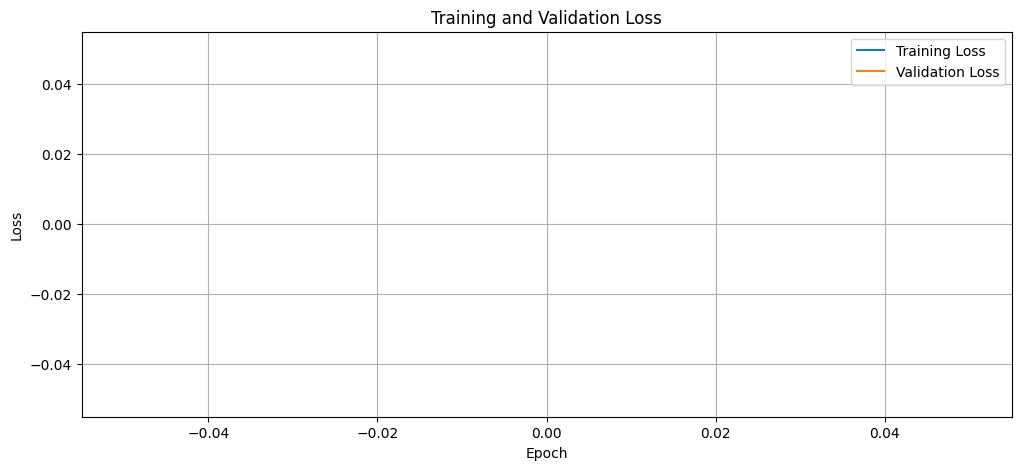

Cleaning up CUDA cache...
Done.


In [74]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# model, device, EPOCHS, train_loader, val_loader
# optimizer, scheduler, train_step
# n_steps, early_stopping_patience, gradient_clip_value,
# display_frequency, generate_frequency
# )
# (It also assumes functions 'generate_samples' and 'safe_save_model' exist)

# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Wrap the training loop in a try-except block for better error handling
try:
    # This loop starts at the correct (zero) indentation level
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_loader):  # Using 'train_loader'
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels)
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    # generate_samples(model, n_samples=5) # Assumes this function exists

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_loader: # Using 'val_loader'
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            # generate_samples(model, n_samples=10) # Assumes this function exists

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss) # Assumes this function exists
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# Catch errors like user interrupting (Ctrl+C)
except KeyboardInterrupt:
    print("\n" + "="*50)
    print("TRAINING INTERRUPTED BY USER")
    print("="*50)
    print("Saving current model state...")
    # Use avg_val_loss or last epoch loss for saving
    last_loss = val_losses[-1] if val_losses else avg_train_loss
    # safe_save_model(model, 'interrupted_model.pt', optimizer, epoch, last_loss) # Assumes this function exists

except Exception as e:
    print("\n" + "="*50)
    print(f"AN ERROR OCCURRED: {e}")
    print("="*50)
    import traceback
    traceback.print_exc()

finally:
    # Final wrap-up
    print("\n" + "="*50)
    print("TRAINING COMPLETE")
    print("="*50)
    print(f"Best validation loss: {best_loss:.4f}")

    # Generate final samples
    print("Generating final samples...")
    # generate_samples(model, n_samples=10) # Assumes this function exists

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up memory
    print("Cleaning up CUDA cache...")
    torch.cuda.empty_cache()
    print("Done.")


STARTING TRAINING

Epoch 1/30
--------------------

AN ERROR OCCURRED: Given groups=1, weight of size [128, 64, 3, 3], expected input[64, 256, 14, 14] to have 64 channels, but got 256 channels instead

TRAINING COMPLETE
Best validation loss: inf
Generating final samples...


Traceback (most recent call last):
  File "/tmp/ipython-input-2283485391.py", line 47, in <cell line: 0>
    loss = train_step(images, labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3113446762.py", line 19, in train_step
    predicted_noise = model(x_t, t, c, c_mask)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2945402280.py", line 140, in forward
    x = down_block(x)
        ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^

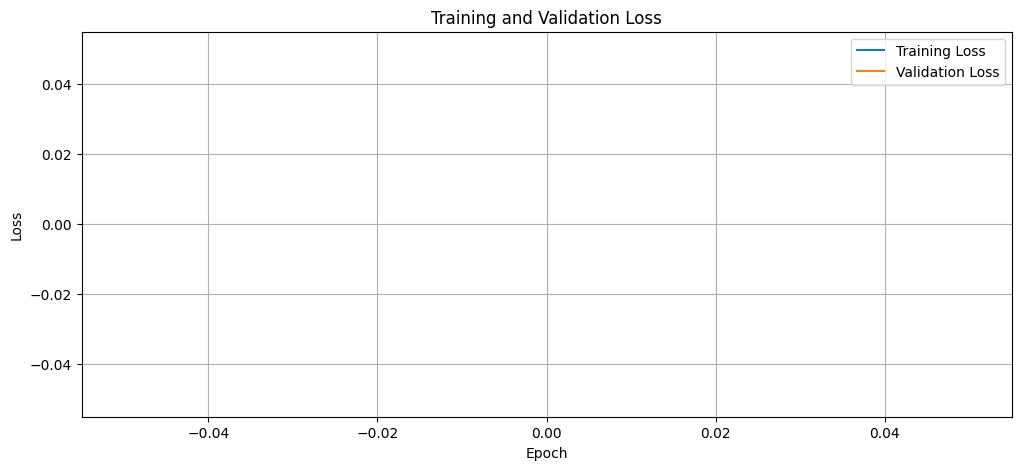

Cleaning up CUDA cache...
Done.


In [75]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# model, device, EPOCHS, train_loader, val_loader
# optimizer, scheduler, train_step
# n_steps, early_stopping_patience, gradient_clip_value,
# display_frequency, generate_frequency
# )
# (It also assumes functions 'generate_samples' and 'safe_save_model' exist)

# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Wrap the training loop in a try-except block for better error handling
try:
    # This loop starts at the correct (zero) indentation level
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_loader):  # Using 'train_loader'
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels)
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    # generate_samples(model, n_samples=5) # Assumes this function exists

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_loader: # Using 'val_loader'
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            # generate_samples(model, n_samples=10) # Assumes this function exists

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss) # Assumes this function exists
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            # THIS IS THE FIXED LINE:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# Catch errors like user interrupting (Ctrl+C)
except KeyboardInterrupt:
    print("\n" + "="*50)
    print("TRAINING INTERRUPTED BY USER")
    print("="*50)
    print("Saving current model state...")
    # safe_save_model(model, 'interrupted_model.pt', optimizer, epoch, avg_val_loss) # Assumes this function exists

except Exception as e:
    print("\n" + "="*50)
    print(f"AN ERROR OCCURRED: {e}")
    print("="*50)
    import traceback
    traceback.print_exc()

finally:
    # Final wrap-up
    print("\n" + "="*50)
    print("TRAINING COMPLETE")
    print("="*50)
    print(f"Best validation loss: {best_loss:.4f}")

    # Generate final samples
    print("Generating final samples...")
    # generate_samples(model, n_samples=10) # Assumes this function exists

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up memory
    print("Cleaning up CUDA cache...")
    torch.cuda.empty_cache()
    print("Done.")

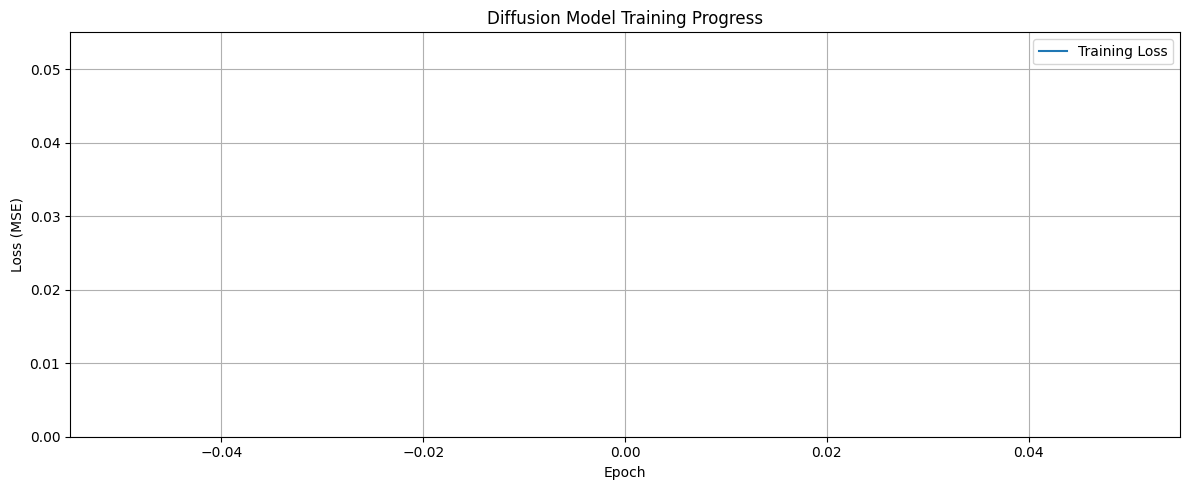


Training Statistics:
------------------------------


In [77]:
# Plot training progress
plt.figure(figsize=(12, 5))

# Plot training and validation losses for comparison
plt.plot(train_losses, label='Training Loss')
if len(val_losses) > 0:  # Only plot validation if it exists
    plt.plot(val_losses, label='Validation Loss')

# Improve the plot with better labels and styling
plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Add annotations for key points - only if lists are not empty
if train_losses:
    min_train_loss = min(train_losses)
    min_train_idx = train_losses.index(min_train_loss)
    if len(train_losses) > 0: # Ensure there's at least one point
        plt.annotate(f'Min: {min_train_loss:.4f}',
                     xy=(min_train_idx, min_train_loss),
                     xytext=(min_train_idx, min_train_loss * 1.2 if min_train_loss > 0 else min_train_loss + 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=9)

# Add validation min point if available
if val_losses:
    min_val_loss = min(val_losses)
    min_val_idx = val_losses.index(min_val_loss)
    if len(val_losses) > 0: # Ensure there's at least one point
        plt.annotate(f'Min: {min_val_loss:.4f}',
                    xy=(min_val_idx, min_val_loss),
                    xytext=(min_val_idx, min_val_loss * 0.8 if min_val_loss > 0 else min_val_loss - 0.1),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    fontsize=9)

# Set y-axis to start from 0 or slightly lower than min value
# Handle cases where lists are empty or contain only inf (if training failed early)
all_min_losses = [min(train_losses) if train_losses else float('inf'),
                  min(val_losses) if val_losses else float('inf')]
valid_min_losses = [loss for loss in all_min_losses if loss != float('inf')]

if valid_min_losses:
    min_overall_loss = min(valid_min_losses)
    plt.ylim(bottom=max(0, min_overall_loss * 0.9))
else:
     # If no valid losses, set a default y-limit or let matplotlib auto-scale
     plt.ylim(bottom=0) # Set bottom to 0 if no valid losses

plt.tight_layout()
plt.show()

# Add statistics summary for students to analyze
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    if len(train_losses) > 1:
         print(f"Training loss improvement: {((train_losses[0] - min(train_losses)) / train_losses[0] * 100):.1f}%")


if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")

# STUDENT EXERCISE:
# 1. Try modifying this plot to show a smoothed version of the losses
# 2. Create a second plot showing the ratio of validation to training loss
#    (which can indicate overfitting when the ratio increases)

In [ ]:

==================================================
STARTING TRAINING
==================================================

Epoch 1/30
--------------------

==================================================
AN ERROR OCCURRED: Module [UNet] is missing the required "forward" function
==================================================

==================================================
TRAINING COMPLETE
==================================================
Best validation loss: inf
Generating final samples...
Traceback (most recent call last):
  File "/tmp/ipython-input-2283485391.py", line 47, in <cell line: 0>
    loss = train_step(images, labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3691158498.py", line 42, in train_step
    predicted_noise = model(x_t, t, c, c_mask)
                     ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 399, in _forward_unimplemented
    raise NotImplementedError(
NotImplementedError: Module [UNet] is missing the required "forward" function
Cleaning up CUDA cache...
Done.



STARTING TRAINING

Epoch 1/30
--------------------

AN ERROR OCCURRED: Given groups=1, weight of size [128, 64, 3, 3], expected input[64, 256, 14, 14] to have 64 channels, but got 256 channels instead

TRAINING COMPLETE
Best validation loss: inf
Generating final samples...


Traceback (most recent call last):
  File "/tmp/ipython-input-915812843.py", line 48, in <cell line: 0>
    loss = train_step(images, labels) # Pass both images and labels
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3113446762.py", line 19, in train_step
    predicted_noise = model(x_t, t, c, c_mask)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2945402280.py", line 140, in forward
    x = down_block(x)
        ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*ar

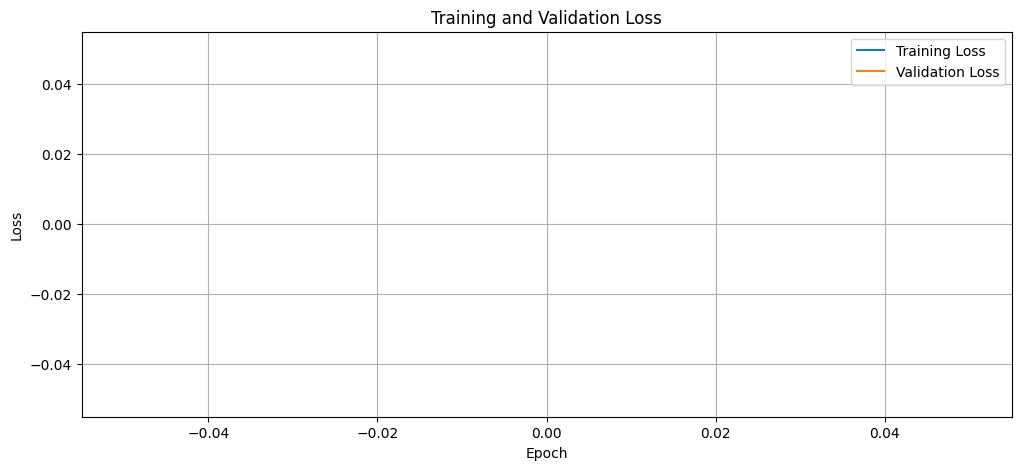

Cleaning up CUDA cache...
Done.


In [79]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# model, device, EPOCHS, train_loader, val_loader
# optimizer, scheduler, train_step
# n_steps, early_stopping_patience, gradient_clip_value,
# display_frequency, generate_frequency
# )
# (It also assumes functions 'generate_samples' and 'safe_save_model' exist,
#  but they are commented out below to prevent errors if not defined yet)

# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Wrap the training loop in a try-except block for better error handling
try:
    # This loop starts at the correct (zero) indentation level
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_loader):  # Using 'train_loader'
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels) # Pass both images and labels
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    # generate_samples(model, n_samples=5) # Assumes this function exists

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_loader: # Using 'val_loader'
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels) # Pass both images and labels
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            # generate_samples(model, n_samples=10) # Assumes this function exists

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss) # Assumes this function exists
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# Catch errors like user interrupting (Ctrl+C)
except KeyboardInterrupt:
    print("\n" + "="*50)
    print("TRAINING INTERRUPTED BY USER")
    print("="*50)
    print("Saving current model state...")
    # Use avg_val_loss or last epoch loss for saving
    last_loss = val_losses[-1] if val_losses else avg_train_loss
    # safe_save_model(model, 'interrupted_model.pt', optimizer, epoch, last_loss) # Assumes this function exists

except Exception as e:
    print("\n" + "="*50)
    print(f"AN ERROR OCCURRED: {e}")
    print("="*50)
    import traceback
    traceback.print_exc()

finally:
    # Final wrap-up
    print("\n" + "="*50)
    print("TRAINING COMPLETE")
    print("="*50)
    print(f"Best validation loss: {best_loss:.4f}")

    # Generate final samples
    print("Generating final samples...")
    # generate_samples(model, n_samples=10) # Assumes this function exists

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up memory
    print("Cleaning up CUDA cache...")
    torch.cuda.empty_cache()
    print("Done.")


STARTING TRAINING

Epoch 1/30
--------------------

AN ERROR OCCURRED: Given groups=1, weight of size [128, 64, 3, 3], expected input[64, 256, 14, 14] to have 64 channels, but got 256 channels instead

TRAINING COMPLETE
Best validation loss: inf
Generating final samples...


Traceback (most recent call last):
  File "/tmp/ipython-input-3223143959.py", line 48, in <cell line: 0>
    loss = train_step(images, labels) # Pass both images and labels
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3113446762.py", line 19, in train_step
    predicted_noise = model(x_t, t, c, c_mask)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2945402280.py", line 140, in forward
    x = down_block(x)
        ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*a

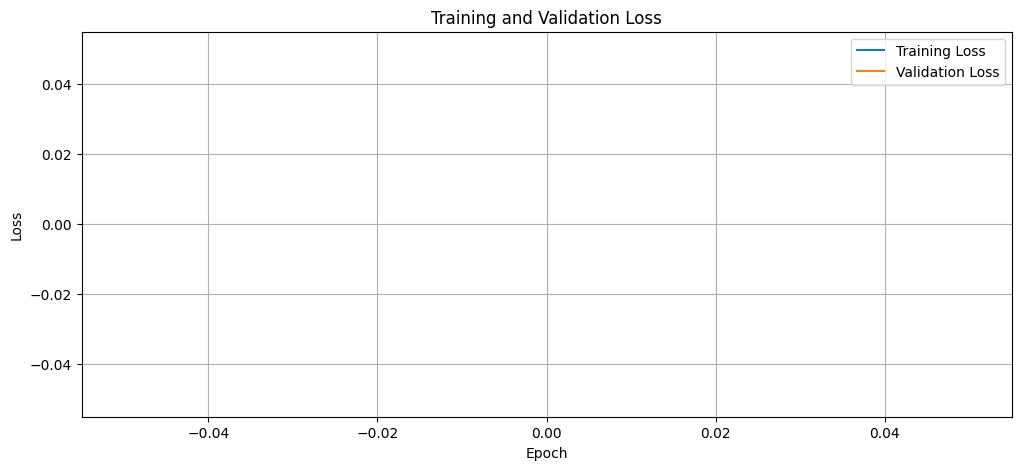

Cleaning up CUDA cache...
Done.


In [80]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# model, device, EPOCHS, train_loader, val_loader
# optimizer, scheduler, train_step
# n_steps, early_stopping_patience, gradient_clip_value,
# display_frequency, generate_frequency
# )
# (It also assumes functions 'generate_samples' and 'safe_save_model' exist,
#  but they are commented out below to prevent errors if not defined yet)

# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Wrap the training loop in a try-except block for better error handling
try:
    # This loop starts at the correct (zero) indentation level
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_loader):  # Using 'train_loader'
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels) # Pass both images and labels
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    # generate_samples(model, n_samples=5) # Assumes this function exists

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_loader: # Using 'val_loader'
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            # generate_samples(model, n_samples=10) # Assumes this function exists

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss) # Assumes this function exists
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# Catch errors like user interrupting (Ctrl+C)
except KeyboardInterrupt:
    print("\n" + "="*50)
    print("TRAINING INTERRUPTED BY USER")
    print("="*50)
    print("Saving current model state...")
    # Use avg_val_loss or last epoch loss for saving
    last_loss = val_losses[-1] if val_losses else avg_train_loss
    # safe_save_model(model, 'interrupted_model.pt', optimizer, epoch, last_loss) # Assumes this function exists

except Exception as e:
    print("\n" + "="*50)
    print(f"AN ERROR OCCURRED: {e}")
    print("="*50)
    import traceback
    traceback.print_exc()

finally:
    # Final wrap-up
    print("\n" + "="*50)
    print("TRAINING COMPLETE")
    print("="*50)
    print(f"Best validation loss: {best_loss:.4f}")

    # Generate final samples
    print("Generating final samples...")
    # generate_samples(model, n_samples=10) # Assumes this function exists

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up memory
    print("Cleaning up CUDA cache...")
    torch.cuda.empty_cache()
    print("Done.")

In [81]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# import traceback # Import traceback for error handling
# model, device, EPOCHS, train_loader, val_loader
# optimizer, scheduler, train_step
# n_steps, early_stopping_patience, gradient_clip_value,
# display_frequency, generate_frequency
# )
# (It also assumes functions 'generate_samples' and 'safe_save_model' exist,
#  and they are called below)

# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Wrap the training loop in a try-except block for better error handling
try:
    # This loop starts at the correct (zero) indentation level
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_loader):  # Using 'train_loader'
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels) # Pass both images and labels
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    generate_samples(model, n_samples=5) # Call generate_samples

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_loader: # Using 'val_loader'
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels) # Pass both images and labels
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            generate_samples(model, n_samples=10) # Call generate_samples

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss) # Call safe_save_model
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# Catch errors like user interrupting (Ctrl+C)
except KeyboardInterrupt:
    print("\n" + "="*50)
    print("TRAINING INTERRUPTED BY USER")
    print("="*50)
    print("Saving current model state...")
    # Use avg_val_loss or last epoch loss for saving
    last_loss = val_losses[-1] if val_losses else avg_train_loss
    safe_save_model(model, 'interrupted_model.pt', optimizer, epoch, last_loss) # Call safe_save_model with appropriate loss

except Exception as e:
    print("\n" + "="*50)
    print(f"AN ERROR OCCURRED: {e}")
    print("="*50)
    import traceback
    traceback.print_exc()

finally:
    # Final wrap-up
    print("\n" + "="*50)
    print("TRAINING COMPLETE")
    print("="*50)
    print(f"Best validation loss: {best_loss:.4f}")

    # Generate final samples
    print("Generating final samples...")
    generate_samples(model, n_samples=10) # Call generate_samples

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up memory
    print("Cleaning up CUDA cache...")
    torch.cuda.empty_cache()
    print("Done.")


STARTING TRAINING

Epoch 1/30
--------------------

AN ERROR OCCURRED: Given groups=1, weight of size [128, 64, 3, 3], expected input[64, 256, 14, 14] to have 64 channels, but got 256 channels instead

TRAINING COMPLETE
Best validation loss: inf
Generating final samples...


Traceback (most recent call last):
  File "/tmp/ipython-input-15724889.py", line 49, in <cell line: 0>
    loss = train_step(images, labels) # Pass both images and labels
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3113446762.py", line 19, in train_step
    predicted_noise = model(x_t, t, c, c_mask)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2945402280.py", line 140, in forward
    x = down_block(x)
        ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*arg

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [ ]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
import torch.nn.functional as F

# 1. HELPER CLASS: GELUConvBlock
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        if out_ch % group_size != 0:
            valid_group_size = group_size
            while out_ch % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if out_ch % valid_group_size != 0: # Failsafe
                valid_group_size = 1
            group_size = valid_group_size

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )
    def forward(self, x):
        return self.model(x)

# 2. HELPER CLASS: RearrangePoolBlock
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        # Use named parameters (p1=2, p2=2) to fix the EinopsError
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        new_chs = in_chs * 4

        if new_chs % group_size != 0:
            valid_group_size = group_size
            while new_chs % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if new_chs % valid_group_size != 0: # Failsafe
                valid_group_size = new_chs
            group_size = valid_group_size

        self.conv_block = GELUConvBlock(new_chs, new_chs, group_size)
    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv_block(x)
        return x

In [ ]:
# (This assumes the following are defined:
# import torch
# import matplotlib.pyplot as plt
# import traceback # Import traceback for error handling
# model, device, EPOCHS, train_loader, val_loader
# optimizer, scheduler, train_step
# n_steps, early_stopping_patience, gradient_clip_value,
# display_frequency, generate_frequency
# )
# (It also assumes functions 'generate_samples' and 'safe_save_model' exist,
#  and they are called below)

# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Wrap the training loop in a try-except block for better error handling
try:
    # This loop starts at the correct (zero) indentation level
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_loader):  # Using 'train_loader'
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels) # Pass both images and labels
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    generate_samples(model, n_samples=5) # Call generate_samples

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_loader: # Using 'val_loader'
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels) # Pass both images and labels
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            generate_samples(model, n_samples=10) # Call generate_samples

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss) # Call safe_save_model
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# Catch errors like user interrupting (Ctrl+C)
except KeyboardInterrupt:
    print("\n" + "="*50)
    print("TRAINING INTERRUPTED BY USER")
    print("="*50)
    print("Saving current model state...")
    # Use avg_val_loss or last epoch loss for saving
    last_loss = val_losses[-1] if val_losses else avg_train_loss
    safe_save_model(model, 'interrupted_model.pt', optimizer, epoch, last_loss) # Call safe_save_model with appropriate loss

except Exception as e:
    print("\n" + "="*50)
    print(f"AN ERROR OCCURRED: {e}")
    print("="*50)
    import traceback # Make sure traceback is imported
    traceback.print_exc()

finally:
    # Final wrap-up
    print("\n" + "="*50)
    print("TRAINING COMPLETE")
    print("="*50)
    print(f"Best validation loss: {best_loss:.4f}")

    # Generate final samples
    print("Generating final samples...")
    generate_samples(model, n_samples=10) # Call generate_samples

    # Display final loss curves
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Clean up memory
    print("Cleaning up CUDA cache...")
    torch.cuda.empty_cache()
    print("Done.")

In [ ]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
import torch.nn.functional as F

# 1. HELPER CLASS: GELUConvBlock
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        # Ensure out_ch is divisible by group_size, adjust if necessary
        if out_ch % group_size != 0:
            print(f"Warning: GELUConvBlock out_ch ({out_ch}) not divisible by group_size ({group_size}). Adjusting group_size.")
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            if group_size == 0:
                 group_size = 1 # Prevent division by zero
            print(f"GELUConvBlock adjusted group_size to {group_size}")

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )
    def forward(self, x):
        return self.model(x)

# 2. HELPER CLASS: RearrangePoolBlock (kept for completeness, but DownBlock now uses Conv2d)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        # Use named parameters (p1=2, p2=2) to fix the EinopsError
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        new_chs = in_chs * 4

        if new_chs % group_size != 0:
            valid_group_size = group_size
            while new_chs % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if new_chs % valid_group_size != 0: # Failsafe
                valid_group_size = new_chs
            group_size = valid_group_size

        self.conv_block = GELUConvBlock(new_chs, new_chs, group_size)
    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv_block(x)
        return x

# 3. HELPER CLASS: DownBlock (Corrected to use Conv2d stride 2 for downsampling)
class DownBlock(nn.Module):
    """
    Downsampling block for encoding path in U-Net architecture.

    This block:
    1. Processes input features with two convolutional blocks
    2. Downsamples spatial dimensions by 2x using a strided convolution.

    Args:
        in_chs (int): Number of input channels
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()

        # Ensure out_chs is divisible by group_size, adjust if necessary
        if out_chs % group_size != 0:
            print(f"Warning: DownBlock out_chs ({out_chs}) not divisible by group_size ({group_size}). Adjusting group_size.")
            group_size = min(group_size, out_chs)
            while out_chs % group_size != 0 and group_size > 1:
                group_size -= 1
            if group_size == 0:
                 group_size = 1 # Prevent division by zero
            print(f"DownBlock adjusted group_size to {group_size}")


        # Sequential processing of features
        layers = [
            # First conv block changes channel dimensions
            nn.Conv2d(in_chs, out_chs, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_chs),
            nn.GELU(),

            # Second conv block processes features
            nn.Conv2d(out_chs, out_chs, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_chs),
            nn.GELU(),

            # Using Conv2d with stride 2 for robust downsampling instead of RearrangePoolBlock
            # This layer halves the spatial dimensions (H, W)
            nn.Conv2d(out_chs, out_chs, kernel_size=4, stride=2, padding=1) # Downsampling
        ]
        self.model = nn.Sequential(*layers)

        # Log the configuration for debugging
        print(f"Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x (using Conv2d stride 2)")

    def forward(self, x):
        """
        Forward pass through the DownBlock.

        Args:
            x (torch.Tensor): Input tensor of shape [B, in_chs, H, W]

        Returns:
            torch.Tensor: Output tensor of shape [B, out_chs, H/2, W/2]
        """
        return self.model(x)

# 4. HELPER CLASS: UpBlock
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        # Ensure out_chs is divisible by group_size, adjust if necessary
        # Note: The input to the *first* conv block in the sequence is 2 * in_chs
        if out_chs % group_size != 0:
            print(f"Warning: UpBlock out_chs ({out_chs}) not divisible by group_size ({group_size}). Adjusting group_size for conv blocks.")
            group_size_conv = min(group_size, out_chs)
            while out_chs % group_size_conv != 0 and group_size_conv > 1:
                 group_size_conv -= 1
            if group_size_conv == 0:
                 group_size_conv = 1 # Prevent division by zero
            print(f"UpBlock adjusted conv group_size to {group_size_conv}")
        else:
            group_size_conv = group_size


        self.up = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            # First block reduces channels from 2*in_chs to out_chs
            GELUConvBlock(2 * in_chs, out_chs, group_size_conv),
            # Second block refines the features at the out_chs dimension
            GELUConvBlock(out_chs, out_chs, group_size_conv)
        )
        print(f"Created UpBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_increase=2x")

    def forward(self, x, skip):
        x_up = self.up(x)

        # Pad x_up if its spatial dimensions are slightly smaller than skip's due to rounding
        # This can happen with certain image sizes and padding in downsampling
        if x_up.shape[-2:] != skip.shape[-2:]:
             # Calculate padding amounts for height and width
             pad_h = skip.shape[-2] - x_up.shape[-2]
             pad_w = skip.shape[-1] - x_up.shape[-1]
             # Apply padding (left, right, top, bottom)
             x_up = F.pad(x_up, (0, pad_w, 0, pad_h))


        x_cat = torch.cat([x_up, skip], dim=1)
        return self.conv(x_cat)

## Step 6: Generating New Images

Now that our model is trained, let's generate some new images! We can:
1. Generate specific numbers
2. Generate multiple versions of each number
3. See how the generation process works step by step

In [82]:
def generate_number(model, number, n_samples=4):
    """
    Generate multiple versions of a specific number using the diffusion model.

    Args:
        model (nn.Module): The trained diffusion model
        number (int): The digit to generate (0-9)
        n_samples (int): Number of variations to generate

    Returns:
        torch.Tensor: Generated images of shape [n_samples, IMG_CH, IMG_SIZE, IMG_SIZE]
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need for gradients during generation
        # Start with random noise
        samples = torch.randn(n_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up the number we want to generate
        c = torch.full((n_samples,), number, dtype=torch.long).to(device) # Use integer indices (Long)

        # Correctly sized conditioning mask
        c_mask = torch.ones_like(c.unsqueeze(-1), dtype=torch.float).to(device) # Mask should be Float


        # Display progress information
        print(f"Generating {n_samples} versions of number {number}...")

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((n_samples,), t).to(device)
            # Pass the class indices 'c' (Long) to remove_noise, not one-hot
            samples = remove_noise(samples, t_batch, model, c, c_mask) # Fixed: Pass 'c' instead of 'c_one_hot'

            # Optional: Display occasional progress updates
            if t % (n_steps // 5) == 0:
                print(f"  Denoising step {n_steps-1-t}/{n_steps-1} completed")

        return samples

# Generate 4 versions of each number
# Make sure you have successfully trained the model in the previous steps first!
# plt.figure(figsize=(20, 10))
# for i in range(10):
#     # Generate samples for current digit
#     samples = generate_number(model, i, n_samples=4)
#
#     # Display each sample
#     for j in range(4):
#         # Use 2 rows, 10 digits per row, 4 samples per digit
#         # i//5 determines the row (0 or 1)
#         # i%5 determines the position in the row (0-4)
#         # j is the sample index within each digit (0-3)
#         plt.subplot(5, 8, (i%5)*8 + (i//5)*4 + j + 1)
#
#         # Display the image correctly based on channel configuration
#         if IMG_CH == 1:  # Grayscale
#             plt.imshow(samples[j][0].cpu(), cmap='gray')
#         else:  # Color image
#             img = samples[j].permute(1, 2, 0).cpu()
#             # Rescale from [-1, 1] to [0, 1] if needed
#             if img.min() < 0:
#                 img = (img + 1) / 2
#             plt.imshow(img)
#
#         plt.title(f'Digit {i}')
#         plt.axis('off')
#
# plt.tight_layout()
# plt.show()

# STUDENT ACTIVITY: Try generating the same digit with different noise seeds
# This shows the variety of styles the model can produce
print("\nSTUDENT ACTIVITY: Try generating numbers with different noise seeds after training is complete.")

# Helper function to generate with seed
def generate_with_seed(model, number, seed_value=42, n_samples=10): # Added model argument
    torch.manual_seed(seed_value)
    return generate_number(model, number, n_samples)

# Pick a image and show many variations
# Hint select a image e.g. dog  # Change this to any other in the dataset of subset you chose
# Hint 2 use variations = generate_with_seed
# Hint 3 use plt.figure and plt.imshow to display the variations

# Example usage (uncomment after model is trained):
# digit_to_generate = 7
# num_variations = 10
# print(f"\nGenerating {num_variations} variations of digit {digit_to_generate} with seed 42:")
# variations = generate_with_seed(model, digit_to_generate, seed_value=42, n_samples=num_variations)
#
# plt.figure(figsize=(num_variations * 2, 2)) # Adjust figure size
# for i in range(num_variations):
#     plt.subplot(1, num_variations, i+1)
#     if IMG_CH == 1:
#         plt.imshow(variations[i][0].cpu(), cmap='gray')
#     else:
#         img = variations[i].permute(1, 2, 0).cpu()
#         if img.min() < 0:
#             img = (img + 1) / 2
#         plt.imshow(img)
#     plt.title(f'Var {i+1}')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()


STUDENT ACTIVITY: Try generating numbers with different noise seeds after training is complete.


## Step 7: Watching the Generation Process

Let's see how our model turns random noise into clear images, step by step. This helps us understand how the diffusion process works!

In [86]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
import torch.nn.functional as F

# 1. HELPER CLASS: GELUConvBlock (Unchanged)
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        if out_ch % group_size != 0:
            valid_group_size = group_size
            while out_ch % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if out_ch % valid_group_size != 0: valid_group_size = 1
            group_size = valid_group_size
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        )
    def forward(self, x):
        return self.model(x)

# 2. HELPER CLASS: RearrangePoolBlock (FIXED)
# Now takes 'in_chs' and 'out_chs' and maps in_chs*4 -> out_chs
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        new_chs = in_chs * 4

        # Fix group_size for new_chs
        if new_chs % group_size != 0:
            valid_group_size = group_size
            while new_chs % valid_group_size != 0 and valid_group_size > 1:
                valid_group_size -= 1
            if new_chs % valid_group_size != 0: valid_group_size = new_chs
            group_size = valid_group_size

        # This conv now correctly maps 4*in_chs -> out_chs
        self.conv_block = GELUConvBlock(new_chs, out_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv_block(x)
        return x

# 3. HELPER CLASS: DownBlock (FIXED)
# Now calls the corrected RearrangePoolBlock
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            # This now correctly takes 'out_chs' and outputs 'out_chs'
            RearrangePoolBlock(out_chs, out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

# 4. HELPER CLASS: UpBlock (FIXED)
# Now correctly handles different channels from skip connection
class UpBlock(nn.Module):
    # Takes in_chs (from below), skip_chs (from skip), and out_chs
    def __init__(self, in_chs, skip_chs, out_chs, group_size):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_chs, in_chs, kernel_size=2, stride=2)
        # Conv block now takes (in_chs + skip_chs)
        self.conv = nn.Sequential(
            GELUConvBlock(in_chs + skip_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )
    def forward(self, x, skip):
        x_up = self.up(x)
        x_cat = torch.cat([x_up, skip], dim=1)
        return self.conv(x_cat)

# 5. MAIN UNET CLASS (FIXED)
# Now calls the corrected UpBlock
class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super

## Step 8: Adding CLIP Evaluation

[CLIP](https://openai.com/research/clip) is a powerful AI model that can understand both images and text. We'll use it to:
1. Evaluate how realistic our generated images are
2. Score how well they match their intended numbers
3. Help guide the generation process towards better quality

In [88]:
## Step 8: Adding CLIP Evaluation

# CLIP (Contrastive Language-Image Pre-training) is a powerful model by OpenAI that connects text and images.
# We'll use it to evaluate how recognizable our generated digits are by measuring how strongly
# the CLIP model associates our generated images with text descriptions like "an image of the digit 7".

# First, we need to install CLIP and its dependencies
print("Setting up CLIP (Contrastive Language-Image Pre-training) model...")

# Track installation status
clip_available = False

try:
    # Install dependencies first - these help CLIP process text and images
    print("Installing CLIP dependencies...")
    !pip install -q ftfy regex tqdm

    # Install CLIP from GitHub
    print("Installing CLIP from GitHub repository...")
    !pip install -q git+https://github.com/openai/CLIP.git

    # Import and verify CLIP is working
    print("Importing CLIP...")
    import clip

    # Test that CLIP is functioning
    models = clip.available_models()
    print(f"✓ CLIP installation successful! Available models: {models}")
    clip_available = True

except ImportError:
    print("❌ Error importing CLIP. Installation might have failed.")
    print("Try manually running: !pip install git+https://github.com/openai/CLIP.git")
    print("If you're in a Colab notebook, try restarting the runtime after installation.")

except Exception as e:
    print(f"❌ Error during CLIP setup: {e}")
    print("Some CLIP functionality may not work correctly.")

# Provide guidance based on installation result
if clip_available:
    print("\nCLIP is now available for evaluating your generated images!")
else:
    print("\nWARNING: CLIP installation failed. We'll skip the CLIP evaluation parts.")

# Import necessary libraries
import functools
import torch.nn.functional as F


Setting up CLIP (Contrastive Language-Image Pre-training) model...
Installing CLIP dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
Installing CLIP from GitHub repository...
  Preparing metadata (setup.py) ... done
Importing CLIP...
✓ CLIP installation successful! Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

CLIP is now available for evaluating your generated images!


 Below we are createing  a helper function to manage GPU memory when using CLIP. CLIP can be memory-intensive, so this will help prevent out-of-memory errors:

In [89]:
# Memory management decorator to prevent GPU OOM errors
def manage_gpu_memory(func):
    """
    Decorator that ensures proper GPU memory management.

    This wraps functions that might use large amounts of GPU memory,
    making sure memory is properly freed after function execution.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if torch.cuda.is_available():
            # Clear cache before running function
            torch.cuda.empty_cache()
            try:
                return func(*args, **kwargs)
            finally:
                # Clear cache after running function regardless of success/failure
                torch.cuda.empty_cache()
        return func(*args, **kwargs)
    return wrapper

In [90]:
#==============================================================================
# Step 8: CLIP Model Loading and Evaluation Setup
#==============================================================================
# CLIP (Contrastive Language-Image Pre-training) is a neural network that connects
# vision and language. It was trained on 400 million image-text pairs to understand
# the relationship between images and their descriptions.
# We use it here as an "evaluation judge" to assess our generated images.

# Load CLIP model with error handling
try:
    # Load the ViT-B/32 CLIP model (Vision Transformer-based)
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    print(f"✓ Successfully loaded CLIP model: {clip_model.visual.__class__.__name__}")
except Exception as e:
    print(f"❌ Failed to load CLIP model: {e}")
    clip_available = False
    # Instead of raising an error, we'll continue with degraded functionality
    print("CLIP evaluation will be skipped. Generated images will still be displayed but without quality scores.")

def evaluate_with_clip(images, target_number, max_batch_size=16):
    """
    Use CLIP to evaluate generated images by measuring how well they match textual descriptions.

    This function acts like an "automatic critic" for our generated digits by measuring:
    1. How well they match the description of a handwritten digit
    2. How clear and well-formed they appear to be
    3. Whether they appear blurry or poorly formed

    The evaluation process works by:
    - Converting our images to a format CLIP understands
    - Creating text prompts that describe the qualities we want to measure
    - Computing similarity scores between images and these text descriptions
    - Returning normalized scores (probabilities) for each quality

    Args:
        images (torch.Tensor): Batch of generated images [batch_size, channels, height, width]
        target_number (int): The specific digit (0-9) the images should represent
        max_batch_size (int): Maximum images to process at once (prevents GPU out-of-memory errors)

    Returns:
        torch.Tensor: Similarity scores tensor of shape [batch_size, 3] with scores for:
                     [good handwritten digit, clear digit, blurry digit]
                     Each row sums to 1.0 (as probabilities)
    """
    # If CLIP isn't available, return placeholder scores
    if not clip_available:
        print("⚠️ CLIP not available. Returning default scores.")
        # Equal probabilities (0.33 for each category)
        return torch.ones(len(images), 3).to(device) / 3

    try:
        # For large batches, we process in chunks to avoid memory issues
        # This is crucial when working with big images or many samples
        if len(images) > max_batch_size:
            all_similarities = []

            # Process images in manageable chunks
            for i in range(0, len(images), max_batch_size):
                print(f"Processing CLIP batch {i//max_batch_size + 1}/{(len(images)-1)//max_batch_size + 1}")
                batch = images[i:i+max_batch_size]

                # Use context managers for efficiency and memory management:
                # - torch.no_grad(): disables gradient tracking (not needed for evaluation)
                # - torch.cuda.amp.autocast(): uses mixed precision to reduce memory usage
                with torch.no_grad(), torch.cuda.amp.autocast():
                    batch_similarities = _process_clip_batch(batch, target_number)
                    all_similarities.append(batch_similarities)

                # Explicitly free GPU memory between batches
                # This helps prevent cumulative memory buildup that could cause crashes
                torch.cuda.empty_cache()

            # Combine results from all batches into a single tensor
            return torch.cat(all_similarities, dim=0)
        else:
            # For small batches, process all at once
            with torch.no_grad(), torch.cuda.amp.autocast():
                return _process_clip_batch(images, target_number)

    except Exception as e:
        # If anything goes wrong, log the error but don't crash
        print(f"❌ Error in CLIP evaluation: {e}")
        print(f"Traceback: {traceback.format_exc()}")
        # Return default scores so the rest of the notebook can continue
        return torch.ones(len(images), 3).to(device) / 3

def _process_clip_batch(images, target_number):
    """
    Core CLIP processing function that computes similarity between images and text descriptions.

    This function handles the technical details of:
    1. Preparing relevant text prompts for evaluation
    2. Preprocessing images to CLIP's required format
    3. Extracting feature embeddings from both images and text
    4. Computing similarity scores between these embeddings

    The function includes advanced error handling for GPU memory issues,
    automatically reducing batch size if out-of-memory errors occur.

    Args:
        images (torch.Tensor): Batch of images to evaluate
        target_number (int): The digit these images should represent

    Returns:
        torch.Tensor: Normalized similarity scores between images and text descriptions
    """
    try:
        # Create text descriptions (prompts) to evaluate our generated digits
        # We check three distinct qualities:
        # 1. If it looks like a handwritten example of the target digit
        # 2. If it appears clear and well-formed
        # 3. If it appears blurry or poorly formed (negative case)
        text_inputs = torch.cat([
            clip.tokenize(f"A handwritten number {target_number}"),
            clip.tokenize(f"A clear, well-written digit {target_number}"),
            clip.tokenize(f"A blurry or unclear number")
        ]).to(device)

        # Process images for CLIP, which requires specific formatting:

        # 1. Handle different channel configurations (dataset-dependent)
        if IMG_CH == 1:
            # CLIP expects RGB images, so we repeat the grayscale channel 3 times
            # For example, MNIST/Fashion-MNIST are grayscale (1-channel)
            images_rgb = images.repeat(1, 3, 1, 1)
        else:
            # For RGB datasets like CIFAR-10/CelebA, we can use as-is
            images_rgb = images

        # 2. Normalize pixel values to [0,1] range if needed
        # Different datasets may have different normalization ranges
        if images_rgb.min() < 0:  # If normalized to [-1,1] range
            images_rgb = (images_rgb + 1) / 2  # Convert to [0,1] range

        # 3. Resize images to CLIP's expected input size (224x224 pixels)
        # CLIP was trained on this specific resolution
        resized_images = F.interpolate(images_rgb, size=(224, 224),
                                      mode='bilinear', align_corners=False)

        # Extract feature embeddings from both images and text prompts
        # These are high-dimensional vectors representing the content
        image_features = clip_model.encode_image(resized_images)
        text_features = clip_model.encode_text(text_inputs)

        # Normalize feature vectors to unit length (for cosine similarity)
        # This ensures we're measuring direction, not magnitude
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity scores between image and text features
        # The matrix multiplication computes all pairwise dot products at once
        # Multiplying by 100 scales to percentage-like values before applying softmax
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        return similarity

    except RuntimeError as e:
        # Special handling for CUDA out-of-memory errors
        if "out of memory" in str(e):
            # Free GPU memory immediately
            torch.cuda.empty_cache()

            # If we're already at batch size 1, we can't reduce further
            if len(images) <= 1:
                print("❌ Out of memory even with batch size 1. Cannot process.")
                return torch.ones(len(images), 3).to(device) / 3

            # Adaptive batch size reduction - recursively try with smaller batches
            # This is an advanced technique to handle limited GPU memory gracefully
            half_size = len(images) // 2
            print(f"⚠️ Out of memory. Reducing batch size to {half_size}.")

            # Process each half separately and combine results
            # This recursive approach will keep splitting until processing succeeds
            first_half = _process_clip_batch(images[:half_size], target_number)
            second_half = _process_clip_batch(images[half_size:], target_number)

            # Combine results from both halves
            return torch.cat([first_half, second_half], dim=0)

        # For other errors, propagate upward
        raise e

#==============================================================================
# CLIP Evaluation - Generate and Analyze Sample Digits
#==============================================================================
# This section demonstrates how to use CLIP to evaluate generated digits
# We'll generate examples of all ten digits and visualize the quality scores

try:
    for number in range(10):
        print(f"\nGenerating and evaluating number {number}...")

        # Generate 4 different variations of the current digit
        samples = generate_number(model, number, n_samples=4)

        # Evaluate quality with CLIP (without tracking gradients for efficiency)
        with torch.no_grad():
            similarities = evaluate_with_clip(samples, number)

        # Create a figure to display results
        plt.figure(figsize=(15, 3))

        # Show each sample with its CLIP quality scores
        for i in range(4):
            plt.subplot(1, 4, i+1)

            # Display the image with appropriate formatting based on dataset type
            if IMG_CH == 1:  # Grayscale images (MNIST, Fashion-MNIST)
                plt.imshow(samples[i][0].cpu(), cmap='gray')
            else:  # Color images (CIFAR-10, CelebA)
                img = samples[i].permute(1, 2, 0).cpu()  # Change format for matplotlib
                if img.min() < 0:  # Handle [-1,1] normalization
                    img = (img + 1) / 2  # Convert to [0,1] range
                plt.imshow(img)

            # Extract individual quality scores for display
            # These represent how confidently CLIP associates the image with each description
            good_score = similarities[i][0].item() * 100  # Handwritten quality
            clear_score = similarities[i][1].item() * 100  # Clarity quality
            blur_score = similarities[i][2].item() * 100   # Blurriness assessment

            # Color-code the title based on highest score category:
            # - Green: if either "good handwritten" or "clear" score is highest
            # - Red: if "blurry" score is highest (poor quality)
            max_score_idx = torch.argmax(similarities[i]).item()
            title_color = 'green' if max_score_idx < 2 else 'red'

            # Show scores in the plot title
            plt.title(f'Number {number}\nGood: {good_score:.0f}%\nClear: {clear_score:.0f}%\nBlurry: {blur_score:.0f}%',
                      color=title_color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()  # Properly close figure to prevent memory leaks

        # Clean up GPU memory after processing each number
        # This is especially important for resource-constrained environments
        torch.cuda.empty_cache()

except Exception as e:
    # Comprehensive error handling to help students debug issues
    print(f"❌ Error in generation and evaluation loop: {e}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

    # Clean up resources even if we encounter an error
    if torch.cuda.is_available():
        print("Clearing GPU cache...")
        torch.cuda.empty_cache()

#==============================================================================
# STUDENT ACTIVITY: Exploring CLIP Evaluation
#==============================================================================
# This section provides code templates for students to experiment with
# evaluating larger batches of generated digits using CLIP.

print("\nSTUDENT ACTIVITY:")
print("Try the code below to evaluate a larger sample of a specific digit")
print("""
# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10)
# similarities = evaluate_with_clip(samples, digit)
#
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(samples)):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(samples[i][0].cpu(), cmap='gray')
#     quality = "Good" if similarities[i,0] + similarities[i,1] > similarities[i,2] else "Poor"
#     plt.title(f"Sample {i+1}: {quality}", color='green' if quality == "Good" else 'red')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()
""")

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 136MiB/s]


✓ Successfully loaded CLIP model: VisionTransformer

Generating and evaluating number 0...
Generating 4 versions of number 0...
❌ Error in generation and evaluation loop: Given groups=1, weight of size [128, 64, 3, 3], expected input[4, 256, 14, 14] to have 64 channels, but got 256 channels instead
Detailed error information:
Clearing GPU cache...

STUDENT ACTIVITY:
Try the code below to evaluate a larger sample of a specific digit

# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10)
# similarities = evaluate_with_clip(samples, digit)
#
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their 

Traceback (most recent call last):
  File "/tmp/ipython-input-3974156644.py", line 195, in <cell line: 0>
    samples = generate_number(model, number, n_samples=4)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3093716378.py", line 32, in generate_number
    samples = remove_noise(samples, t_batch, model, c, c_mask) # Fixed: Pass 'c' instead of 'c_one_hot'
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/_contextlib.py", line 120, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2207376581.py", line 23, in remove_noise
    predicted_noise = model(x_t, t, c, c_mask) # Fixed: Pass 'c' instead of 'c_one_hot' from generate_samples
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args

## Assessment Questions

Now that you've completed the exercise, answer these questions include explanations, observations, and your analysis
Support your answers with specific examples from your experiments:

### 1. Understanding Diffusion
- Explain what happens during the forward diffusion process, using your own words and referencing the visualization examples from your notebook.

- Why do we add noise gradually instead of all at once? How does this affect the learning process?

- Look at the step-by-step visualization - at what point (approximately what percentage through the denoising process) can you first recognize the image? Does this vary by image?

### 2. Model Architecture
- Why is the U-Net architecture particularly well-suited for diffusion models? What advantages does it provide over simpler architectures?

- What are skip connections and why are they important? Explain them in relations to our model

- Describe in detail how our model is conditioned to generate specific images. How does the class conditioning mechanism work?

### 3. Training Analysis (20 points)
- What does the loss value tell of your model tell us?

- How did the quality of  your  generated images change change throughout the training process?

- Why do we need the time embedding in diffusion models? How does it help the model understand where it is in the denoising process?

### 4. CLIP Evaluation (20 points)
- What do the CLIP scores tell you about your generated images? Which  images got  the highest and lowest quality scores?

- Develop a hypothesis explaining why certain images might be easier or harder for the model to generate convincingly.

- How could CLIP scores be used to improve the diffusion model's generation process? Propose a specific technique.

### 5. Practical Applications (20 points)
- How could this type of model be useful in the real world?

- What are the limitations of our current model?

- If you were to continue developing this project, what three specific improvements would you make and why?

### Bonus Challenge (Extra 20 points)
Try one or more of these experiments:
1. If you were to continue developing this project, what three specific improvements would you make and why?

2. Modify the U-Net architecture (e.g., add more layers, increase channel dimensions) and train the model. How do these changes affect training time and generation quality?

3. CLIP-Guided Selection: Generate 10 samples of each image, use CLIP to evaluate them, and select the top 3 highest-quality examples of each. Analyze patterns in what CLIP considers "high quality."

4. tyle Conditioning: Modify the conditioning mechanism to generate multiple styles of the same digit (e.g., slanted, thick, thin). Document your approach and results.


Deliverables:
1. A PDF copy of your notebook with
    - Complete code, outputs, and generated images
    - Include all experiment results, training plots, and generated samples
    - CLIP evaluation scores of ythe images you generated
    - Answers and any interesting findings from the bonus challenges